# "Hallelujah Effect" Analysis with SVMs

This notebook models the "Hallelujah Effect" in terms of all basic features available in the dataset for those subjects that listened to the song and had an EDA quality >80% using various SVM models.

In [1]:
import numpy as np
# import shutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn.svm import SVC
# from sklearn import metrics
# from sklearn.model_selection import cross_val_score
from google.cloud import bigquery as bq

In [2]:
# Set bucket, project, and region
BUCKET = 'eim-muse'
PROJECT = 'eim-muse'
REGION = 'us-east1'

In [3]:
# Set a random state variable for repeatability
RANDOM_STATE = 42

In [4]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../service_account_key.json'

In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Retrieve and Subset Datasource

Get data from BigQuery but defer filtering, etc. to Beam. Data in BigQuery has been pre-processed with Dataprep.

In [6]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT *
FROM
  `eim-muse.hallelujah_effect.full_hallelujah_trials_cleaned`
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) < 7".format(base_query)
    else:
      # Validation
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) >= 7".format(base_query)
  else:
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), {1}) = {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(1, None)

In [7]:
client = bq.Client()
df_all = client.query(query).to_dataframe()
df_all.head()
df_all.describe()

age  concentration  musical_expertise    artistic       fault  \
count  303.000000     303.000000         303.000000  303.000000  303.000000   
mean    24.726073       3.993500           2.547224    2.344099    3.175612   
std     13.931034       0.795258           1.009324    0.988361    0.891464   
min      1.000000       1.000000           1.000000    1.000000    1.000000   
25%     16.000000       3.991266           2.000000    2.000000    3.000000   
50%     21.000000       3.991266           2.529880    2.353712    3.144737   
75%     31.000000       4.000000           3.000000    2.353712    4.000000   
max    121.000000       5.000000           5.000000    5.000000    5.000000   

       imagination        lazy     nervous    outgoing    reserved  \
count   303.000000  303.000000  303.000000  303.000000  303.000000   
mean      3.852643    3.690403    3.629726    3.213016    3.145503   
std       0.821620    0.905895    0.875898    0.961299    0.891699   
min       1.000000    1.000000    1.000000    1.000000    1.000000   
25%       3.824561    3.659389    3.596491    3.000000    3.000000   
50%       3.824561    3.659389    3.596491    3.228070    3.117904   
75%       4.000000    4.000000    4.000000    4.000000    4.000000   
max       5.000000    5.000000    5.000000    5.000000    5.000000   

                   ...               music_pref_none  music_pref_hiphop  \
count              ...                    303.000000         303.000000   
mean               ...                      0.006601           0.138614   
std                ...                      0.081110           0.346115   
min                ...                      0.000000           0.000000   
25%                ...                      0.000000           0.000000   
50%                ...                      0.000000           0.000000   
75%                ...                      0.000000           0.000000   
max                ...                      1.000000           1.000000   

       music_pref_dance  music_pref_world  music_pref_rock  music_pref_pop  \
count        303.000000        303.000000       303.000000      303.000000   
mean           0.188119          0.132013         0.432343        0.673267   
std            0.391454          0.339065         0.496221        0.469794   
min            0.000000          0.000000         0.000000        0.000000   
25%            0.000000          0.000000         0.000000        0.000000   
50%            0.000000          0.000000         0.000000        1.000000   
75%            0.000000          0.000000         1.000000        1.000000   
max            1.000000          1.000000         1.000000        1.000000   

       music_pref_classical  music_pref_jazz  music_pref_folk  \
count            303.000000       303.000000       303.000000   
mean               0.306931         0.171617         0.089109   
std                0.461983         0.377671         0.285372   
min                0.000000         0.000000         0.000000   
25%                0.000000         0.000000         0.000000   
50%                0.000000         0.000000         0.000000   
75%                1.000000         0.000000         0.000000   
max                1.000000         1.000000         1.000000   

       music_pref_traditional_irish  
count                    303.000000  
mean                       0.059406  
std                        0.236774  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        0.000000  
max                        1.000000  

[8 rows x 29 columns]

In [8]:
def preprocess_df(df, scaling_dict=None):
  """
  Preprocess a dataframe for this analysis.
  
  If a scaling dict is provided, columns are scaled between 0 and 1. If a scaling
  dict is provided, each column name in the dataframe should have a key in the 
  scaling dict with the same name. The value of this key should itself be a dict
  with 'min' and 'max' keys.
  
  If no scaling dict is provided, one is calculated and returned in the response. 
  This scaling dict can then be used in transforming another dataset (for example,
  to apply the same transformation to an evaluation dataset that was used in scaling 
  a training dataset).
  """

  updated_df = df.drop(labels=['id', 'hallelujah_reaction'], axis=1)

  updated_df = pd.concat(
    [
      updated_df.drop(labels=['location', 'nationality', 'sex', 'language'], axis=1), 
      pd.get_dummies(updated_df['location'], prefix='location'),
      pd.get_dummies(updated_df['nationality'], prefix='nationality'),
      pd.get_dummies(updated_df['sex'], prefix='sex'),
      pd.get_dummies(updated_df['language'], prefix='language')
    ], 
    axis=1
  )

  updated_df = updated_df.apply(pd.to_numeric)

  if scaling_dict is None:
    scaling_dict = {}
    for column in updated_df.columns:
      scaling_dict[column] = {
        'max': updated_df[column].max(),
        'min': updated_df[column].min()
      }
  
  for column in updated_df.columns:
    if column not in scaling_dict.keys():
      updated_df = updated_df.drop(labels=[column], axis=1)
    else:
      updated_df[column] = np.subtract(updated_df[column], scaling_dict[column]['min'], dtype=np.float32)
      updated_df[column] = updated_df[column] / np.subtract(scaling_dict[column]['max'], scaling_dict[column]['min'], dtype=np.float32)

  return updated_df, scaling_dict

In [9]:
from sklearn.decomposition import PCA

df_all_X, _ = preprocess_df(df_all)

pca = PCA(n_components=10, random_state=RANDOM_STATE)
pca = pca.fit(df_all_X)

In [10]:
pca.explained_variance_ratio_

array([ 0.2892389 ,  0.10510198,  0.0626243 ,  0.04989951,  0.04816514,
        0.0426365 ,  0.03729532,  0.03372952,  0.0315414 ,  0.02593562])

In [11]:
pca.components_

array([[  2.91994760e-02,  -6.24282959e-03,   1.60877491e-02,
          1.46415433e-02,   2.63059727e-03,  -8.73568074e-05,
         -5.76951170e-03,  -1.27979134e-02,  -1.22365948e-02,
         -4.85331021e-04,  -3.17351451e-04,   8.48536806e-04,
          4.99643897e-03,  -6.43469297e-03,  -7.15731760e-03,
         -2.11163198e-01,   1.39214880e-01,  -2.21942777e-01,
         -1.74389657e-01,  -6.81630285e-02,   1.04557907e-03,
          6.16310230e-02,   1.02130489e-01,   5.56070684e-02,
          2.24614162e-01,  -5.70909968e-02,  -2.11092929e-02,
          4.26187978e-02,  -5.61281374e-02,   7.05027362e-02,
          3.92089498e-01,  -7.46426458e-02,  -3.17446853e-01,
         -3.85334069e-03,   1.56014038e-02,  -1.61737855e-03,
          3.81612173e-04,   2.68628682e-01,  -2.58911125e-03,
          1.06408564e-01,  -7.59958606e-04,  -3.80888193e-01,
         -1.31227991e-03,  -9.45900792e-02,   9.45900792e-02,
          3.92089498e-01,  -3.20655075e-01,  -7.14344230e-02],
       

In [12]:
var_ratios = pca.explained_variance_ratio_
loadings = pca.components_

pca_df_dict = {}
labels = list()

for i, ratio in enumerate(var_ratios):
    label = '{}: {:4.2f}%'.format(i + 1, ratio * 100)
    labels.append(label)
    pca_df_dict[label] = np.abs(loadings[i])
    
pca_df = pd.DataFrame(pca_df_dict, columns=labels, index=df_all_X.columns)
pca_df

1: 28.92%  2: 10.51%  3: 6.26%  4: 4.99%  \
age                            0.029199   0.013019  0.017065  0.036852   
concentration                  0.006243   0.002017  0.045559  0.005849   
hearing_impairments            0.016088   0.032816  0.004603  0.010159   
musical_expertise              0.014642   0.004041  0.107201  0.049568   
artistic                       0.002631   0.055512  0.067090  0.033303   
fault                          0.000087   0.020353  0.056428  0.005229   
imagination                    0.005770   0.006944  0.052462  0.020356   
lazy                           0.012798   0.051321  0.093389  0.044570   
nervous                        0.012237   0.030551  0.011093  0.067308   
outgoing                       0.000485   0.002054  0.005592  0.037953   
reserved                       0.000317   0.033151  0.053771  0.004471   
stress                         0.000849   0.003665  0.043380  0.004014   
thorough                       0.004996   0.014194  0.011157  0.017801   
trusting                       0.006435   0.030344  0.019533  0.026856   
activity                       0.007157   0.053477  0.016696  0.008209   
engagement                     0.211163   0.035309  0.007873  0.036122   
familiarity                    0.139215   0.073244  0.090361  0.042572   
like_dislike                   0.221943   0.048520  0.053932  0.063287   
positivity                     0.174390   0.024098  0.051165  0.077528   
tension                        0.068163   0.008030  0.047903  0.016882   
music_pref_none                0.001046   0.007768  0.019936  0.013017   
music_pref_hiphop              0.061631   0.045650  0.261083  0.090622   
music_pref_dance               0.102130   0.019705  0.213239  0.001280   
music_pref_world               0.055607   0.017279  0.231813  0.084382   
music_pref_rock                0.224614   0.055925  0.345749  0.154776   
music_pref_pop                 0.057091   0.205360  0.333163  0.455125   
music_pref_classical           0.021109   0.021214  0.507469  0.449921   
music_pref_jazz                0.042619   0.034847  0.465357  0.155923   
music_pref_folk                0.056128   0.021399  0.072832  0.085154   
music_pref_traditional_irish   0.070503   0.012290  0.069070  0.045349   
location_dublin                0.392089   0.056244  0.057744  0.033938   
location_taichung_city         0.074643   0.106538  0.060947  0.466286   
location_taipei_city           0.317447   0.162781  0.003202  0.432348   
nationality_american           0.003853   0.005690  0.009163  0.013217   
nationality_british            0.015601   0.016249  0.001775  0.003548   
nationality_chinese            0.001617   0.003405  0.007322  0.017190   
nationality_indonesian         0.000382   0.006012  0.002464  0.005048   
nationality_irish              0.268629   0.046062  0.031206  0.016067   
nationality_japanese           0.002589   0.005532  0.000350  0.025428   
nationality_other              0.106409   0.020344  0.015640  0.028546   
nationality_singaporean        0.000760   0.005962  0.002046  0.011117   
nationality_taiwanese          0.380888   0.028854  0.055749  0.120715   
nationality_thai               0.001312   0.005768  0.004109  0.000554   
sex_female                     0.094590   0.660151  0.078330  0.147066   
sex_male                       0.094590   0.660151  0.078330  0.147066   
language_NA                    0.392089   0.056244  0.057744  0.033938   
language_en                    0.320655   0.023560  0.159078  0.121672   
language_zh_TW                 0.071434   0.079804  0.101334  0.087734   

                              5: 4.82%  6: 4.26%  7: 3.73%  8: 3.37%  \
age                           0.005876  0.004152  0.000919  0.009846   
concentration                 0.096691  0.054706  0.077842  0.065249   
hearing_impairments           0.004736  0.058707  0.048104  0.079509   
musical_expertise             0.038570  0.027168  0.022765  0.038216   
artistic                      0.052428  0.0

In [22]:
# Preprocess the training and eval dataframes

# First, preprocess the training set and save the scaling_dict
df_train_X, df_train_scaling_dict = preprocess_df(df_train)
df_train_y = df_train['hallelujah_reaction']

# Now, preprocess the evaluation set, but use the same scaling parameters
# that were calculated for the training set
df_eval_X, _ = preprocess_df(df_eval, scaling_dict=df_train_scaling_dict)
df_eval_y = df_eval['hallelujah_reaction']

# Remove columns from training data that do not exist in eval data
all_columns = list(set(list(df_train_X.columns) + list(df_eval_X.columns)))
good_columns = [column for column in all_columns if column in df_train_X.columns and column in df_eval_X.columns]
df_train_X = df_train_X[good_columns]
df_eval_X = df_eval_X[good_columns]

## Build / Evaluate Baseline Classifier
Construct a baseline classifier for comparison against our other classifiers. Because of class imbalance, this classifier predicts every example to be in the `False` class.

In [23]:
def print_classifier_results(classifier, df_eval_X, df_eval_y):
    
    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier.predict(df_eval_X)
    eval_probs = classifier.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # Print results for best classifier
    print('Results for baseline classifier:')
    print('\n')
    print('Overall F1 score: {}'.format(f1))
    print('True positives: {}'.format(tp))
    print('True negatives: {}'.format(tn))
    print('False positives: {}'.format(fp))
    print('False negatives: {}'.format(fn))
    print('\n')
    print(report)

    # Plot ROC curve for best classifier
    lw = 2
    figure = plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (RBF Kernel)')
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Plot precision-recall curve for best classifier
    figure = plt.figure(figsize=(12,8))
    plt.step(recall, precision, where='post', lw=lw)
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (RBF Kernel)'.format(average_precision))
    plt.tight_layout()

In [24]:
def get_baseline_classifier(df_train_X, df_train_y, constant):

    from sklearn.dummy import DummyClassifier

    classifier_baseline = DummyClassifier(strategy='constant', random_state=RANDOM_STATE, constant=constant)
    classifier_baseline = classifier_baseline.fit(df_train_X, df_train_y)
    
    return classifier_baseline

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results for baseline classifier:


Overall F1 score: 0.0
True positives: 0
True negatives: 41
False positives: 0
False negatives: 20


             precision    recall  f1-score   support

      False       0.67      1.00      0.80        41
       True       0.00      0.00      0.00        20

avg / total       0.45      0.67      0.54        61



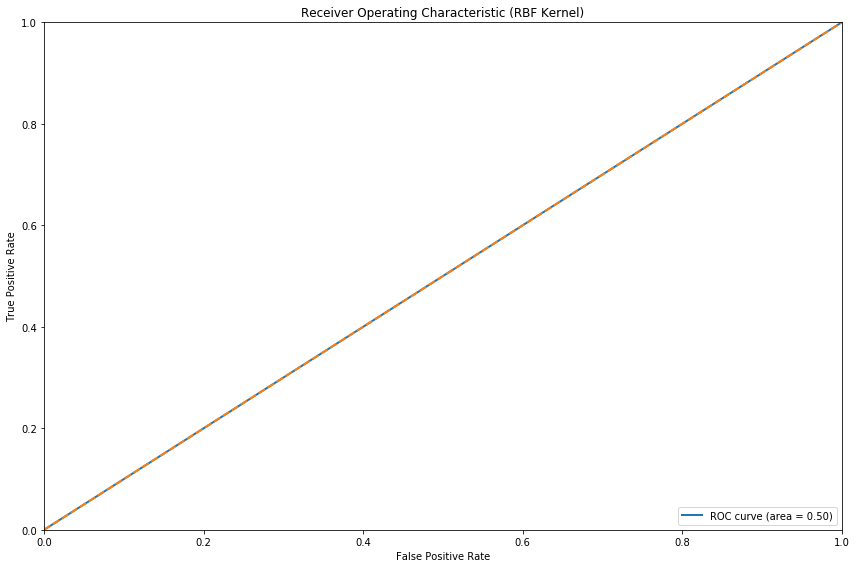

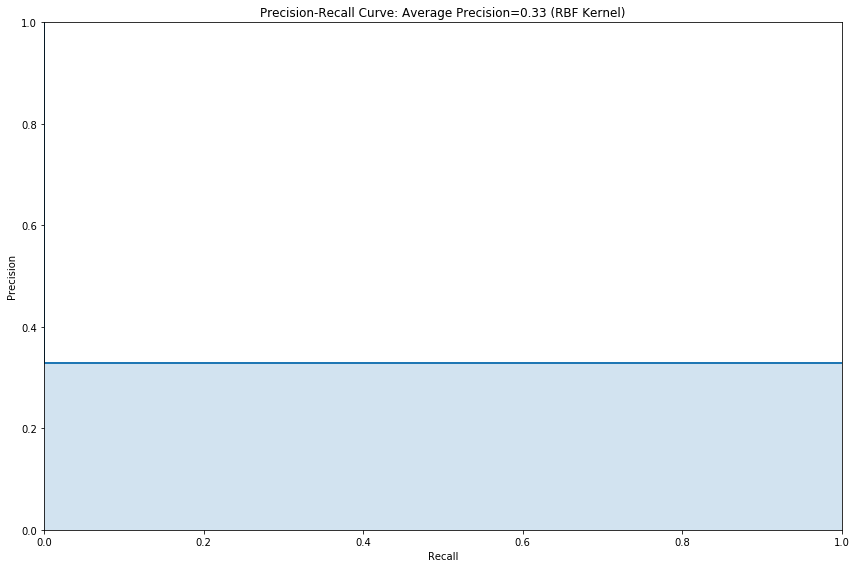

In [27]:
classifier_baseline_false = get_baseline_classifier(df_train_X, df_train_y, False)
print_classifier_results(classifier_baseline_false, df_eval_X, df_eval_y)

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results for baseline classifier:


Overall F1 score: 0.49382716049382713
True positives: 20
True negatives: 0
False positives: 41
False negatives: 0


             precision    recall  f1-score   support

      False       0.00      0.00      0.00        41
       True       0.33      1.00      0.49        20

avg / total       0.11      0.33      0.16        61



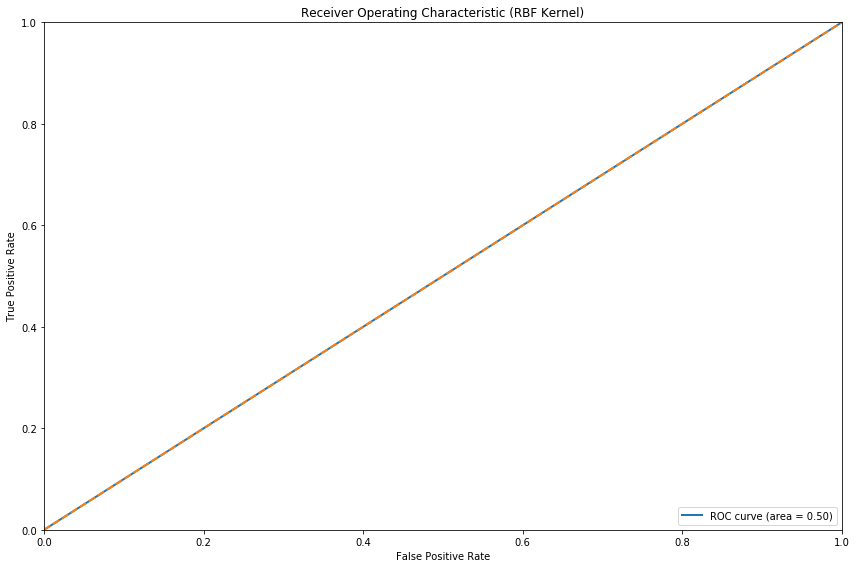

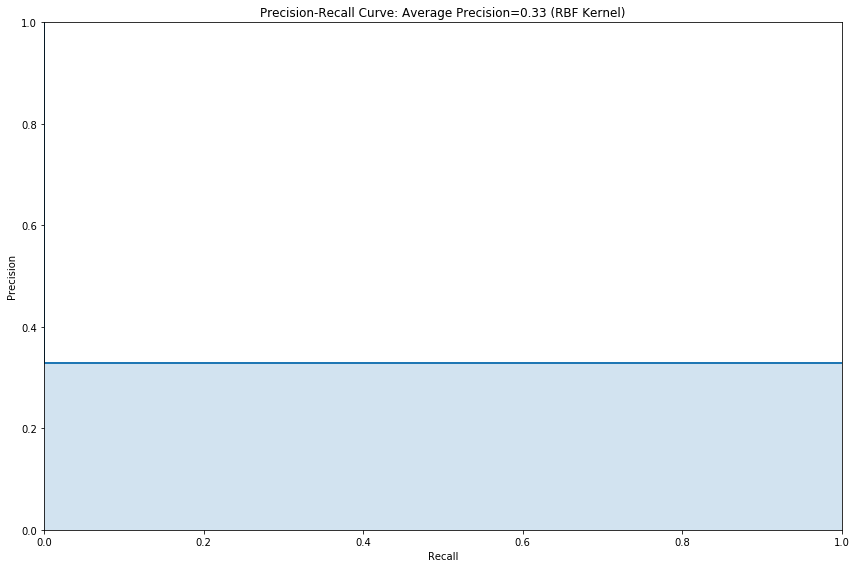

In [236]:
classifier_baseline_true = get_baseline_classifier(df_train_X, df_train_y, True)
print_classifier_results(classifier_baseline_true, df_eval_X, df_eval_y)

## Build SVC classifier (RBF Kernel)

Now, we build an SVM classifier and trial various parameters:

- Kernel: RBF, sigmoid, polynomial, linear

for the $C \in [0.01, 100000]$ term in the model (the error penalization term). This model uses a radial basis function (RBF) kernel.

Fitting 10 folds for each of 1134 candidates, totalling 11340 fits
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0483s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................
[CV] C=0.03125, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=0.03125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    0.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................
[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................
[CV] C=0.03125, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=0.03125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    0.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=0.03125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.000244140625, kernel=sigmoid .................
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................
[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................
[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................
[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  96 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 104 tasks      | elapsed:    1.1s
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................
[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................
[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................
[CV] C=0.03125, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=rbf ........................
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................
[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................
[CV]  C=0.03125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................
[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................
[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................
[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 112 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    1.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................
[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.00390625, kernel=sigmoid .....................
[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................
[CV] C=0.03125, gamma=0.0078125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................
[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................
[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................
[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 152 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 168 tasks      | elapsed:    1.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................
[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................
[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=rbf ...........................
[CV] C=0.03125, gamma=0.0078125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................
[CV] C=0.03125, gamma=0.015625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................
[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 176 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 184 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................
[CV] C=0.03125, gamma=0.03125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.03125, kernel=rbf ............................
[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................
[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................
[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................
[CV] C=0.03125, gamma=0.0625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 208 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 216 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 224 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:    2.6s
[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................
[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................
[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................
[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=rbf ..............................
[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.0625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................
[CV] . C=0.03125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.125, kernel=sigmoid ..........................
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................
[Parallel(n_jobs=4)]: Done 240 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 256 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:    3.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................
[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.5, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.5, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.25, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................
[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.5, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.25, kernel=sigmoid ...........................
[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.5, kernel=rbf ................................
[CV] C=0.03125, gamma=0.5, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 288 tasks      | elapsed:    3.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................
[CV] ... C=0.03125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................
[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 296 tasks      | elapsed:    3.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV] C=0.03125, gamma=1.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1.0, kernel=sigmoid ............................
[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 304 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 320 tasks      | elapsed:    4.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=2.0, kernel=rbf ................................
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV] ... C=0.03125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=2.0, kernel=sigmoid ............................
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 328 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:    4.5s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 344 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 352 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    4.7s
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=8.0, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................
[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, gamma=8.0, kernel=rbf ................................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 392 tasks      | elapsed:    5.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=0.0625, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=0.0625, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 400 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 408 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 416 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 424 tasks      | elapsed:    5.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 432 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 440 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 448 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 456 tasks      | elapsed:    6.0s
[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................
[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=rbf .......................
[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................
[CV] C=0.0625, gamma=0.00048828125, kernel=sigmoid ...................
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 464 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 472 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 480 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    6.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................
[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=0.0625, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................
[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................
[CV] C=0.0625, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=0.0625, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 496 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 512 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 520 tasks      | elapsed:    6.8s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=0.0625, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................
[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 528 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 544 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    7.3s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.015625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV]  C=0.0625, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV] C=0.0625, gamma=0.015625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................
[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 560 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 568 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 576 tasks      | elapsed:    7.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=0.0625, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 584 tasks      | elapsed:    7.8s
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=0.0625, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 592 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 600 tasks      | elapsed:    8.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.0625, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.0625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................
[CV]  C=0.0625, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................
[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 608 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 616 tasks      | elapsed:    8.3s
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................
[CV] .. C=0.0625, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................
[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................
[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 624 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 632 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    8.7s
[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................
[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................
[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[CV] ... C=0.0625, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................
[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................
[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.25, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[CV]  C=0.0625, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 648 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 656 tasks      | elapsed:    9.1s
[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=0.5, kernel=rbf .................................
[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................
[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=0.5, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.0625, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 664 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 672 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 680 tasks      | elapsed:    9.4s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................
[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=1.0, kernel=rbf .................................
[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................
[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=1.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................
[CV] .... C=0.0625, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................
[CV] C=0.0625, gamma=2.0, kernel=rbf .................................
[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=4.0, kernel=rbf .................................
[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=0.0625, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=4.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 688 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 696 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 704 tasks      | elapsed:    9.9s
[CV] C=0.0625, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=4.0, kernel=rbf .................................
[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=4.0, kernel=rbf .................................
[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 712 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 720 tasks      | elapsed:   10.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=8.0, kernel=rbf .................................
[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=0.0625, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................
[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................
[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 736 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   10.6s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................
[CV] C=0.0625, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, gamma=8.0, kernel=sigmoid .............................
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.0625, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=0.125, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 752 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 760 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 768 tasks      | elapsed:   10.8s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=0.125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 776 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 784 tasks      | elapsed:   11.1s
[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=0.125, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 800 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 808 tasks      | elapsed:   11.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=0.125, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 816 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 832 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 840 tasks      | elapsed:   11.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=rbf ........................
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................
[CV] C=0.125, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=0.125, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 848 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 856 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 864 tasks      | elapsed:   12.0s
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 872 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 880 tasks      | elapsed:   12.3s
[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................
[CV] C=0.125, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=0.125, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................
[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................
[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................
[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 888 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 896 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 904 tasks      | elapsed:   12.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=rbf ............................
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 912 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 920 tasks      | elapsed:   12.9s
[CV]  C=0.125, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.015625, kernel=rbf .............................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 928 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 936 tasks      | elapsed:   13.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=0.125, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.015625, kernel=sigmoid .........................
[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 944 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 952 tasks      | elapsed:   13.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.03125, kernel=rbf ..............................
[CV]  C=0.125, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................
[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV] . C=0.125, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.03125, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 960 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 968 tasks      | elapsed:   13.6s
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.125, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] C=0.125, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=rbf ...............................
[CV] C=0.125, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=rbf ................................
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.125, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.125, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 976 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 984 tasks      | elapsed:   13.9s
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................
[CV] C=0.125, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.0625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................
[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................
[CV]  C=0.125, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=rbf ................................
[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................
[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................
[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................
[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 992 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 1000 tasks      | elapsed:   14.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................
[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.125, kernel=rbf ................................
[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.125, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................
[CV] C=0.125, gamma=0.125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................
[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................
[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................
[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1008 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done 1016 tasks      | elapsed:   14.5s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................
[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................
[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................
[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.5, kernel=rbf ..................................
[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................
[CV] C=0.125, gamma=0.25, kernel=sigmoid .............................
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................
[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................
[Parallel(n_jobs=4)]: Done 1024 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 1032 tasks      | elapsed:   14.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.125, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................
[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................
[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1040 tasks      | elapsed:   14.9s
[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=1.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=0.5, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=0.5, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................
[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1048 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 1056 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 1064 tasks      | elapsed:   15.3s
[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................
[CV] C=0.125, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=2.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 1072 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:   15.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.125, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=2.0, kernel=rbf ..................................
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 1088 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 1096 tasks      | elapsed:   15.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................
[CV] C=0.125, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=8.0, kernel=rbf ..................................
[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................
[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................
[CV] C=0.125, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................
[Parallel(n_jobs=4)]: Done 1104 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done 1112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 1120 tasks      | elapsed:   16.3s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=8.0, kernel=rbf ..................................
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.125, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, gamma=8.0, kernel=rbf ..................................
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.125, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.125, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 1128 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 1136 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 1152 tasks      | elapsed:   16.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=0.25, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................
[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1160 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 1168 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 1176 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 1184 tasks      | elapsed:   17.1s
[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................
[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1192 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 1200 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 1208 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 1216 tasks      | elapsed:   17.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=0.25, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=0.25, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=0.25, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1224 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 1232 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 1240 tasks      | elapsed:   17.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=0.25, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=0.25, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1248 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 1256 tasks      | elapsed:   18.2s
[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=0.25, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................
[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................
[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=0.25, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 1264 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 1280 tasks      | elapsed:   18.5s
[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................
[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................
[CV] C=0.25, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................
[CV]  C=0.25, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................
[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1288 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 1296 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 1304 tasks      | elapsed:   18.9s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................
[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0078125, kernel=sigmoid .........................
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=0.25, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 1312 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 1320 tasks      | elapsed:   19.2s
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=rbf ..............................
[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.25, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.015625, kernel=sigmoid ..........................
[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................
[CV]  C=0.25, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0625, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................
[CV] C=0.25, gamma=0.0625, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1328 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 1336 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 1344 tasks      | elapsed:   19.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0625, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] .. C=0.25, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................
[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................
[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.0625, kernel=rbf ................................
[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1352 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 1360 tasks      | elapsed:   19.9s
[CV] ... C=0.25, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.0625, kernel=sigmoid ............................
[CV] C=0.25, gamma=0.125, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.25, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1368 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 1376 tasks      | elapsed:   20.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................
[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.125, kernel=rbf .................................
[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.25, kernel=rbf ..................................
[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.125, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................
[CV] .... C=0.25, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................
[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................
[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.125, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1384 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 1392 tasks      | elapsed:   20.4s
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................
[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.25, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................
[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=rbf ..................................
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 1408 tasks      | elapsed:   20.6s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................
[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.25, kernel=sigmoid ..............................
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.25, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................
[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................
[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=0.25, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1416 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 1424 tasks      | elapsed:   21.0s
[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................
[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=0.5, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................
[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................
[Parallel(n_jobs=4)]: Done 1432 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 1440 tasks      | elapsed:   21.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=2.0, kernel=rbf ...................................
[CV] .. C=0.25, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=4.0, kernel=rbf ...................................
[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=2.0, kernel=rbf ...................................
[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=2.0, kernel=rbf ...................................
[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1448 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 1456 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 1464 tasks      | elapsed:   21.7s
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................
[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................
[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................
[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................
[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................
[Parallel(n_jobs=4)]: Done 1472 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 1480 tasks      | elapsed:   21.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................
[CV] C=0.25, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=4.0, kernel=rbf ...................................
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 1488 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 1496 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 1504 tasks      | elapsed:   22.3s
[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.25, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] .. C=0.25, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=3.0517578125e-05, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 1512 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 1520 tasks      | elapsed:   22.6s
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1528 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 1536 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 1544 tasks      | elapsed:   22.9s
[CV]  C=0.5, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=0.5, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=0.5, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1552 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 1568 tasks      | elapsed:   23.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.5, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 1584 tasks      | elapsed:   23.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................
[CV] C=0.5, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1592 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 1600 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 1608 tasks      | elapsed:   23.7s
[CV]  C=0.5, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=0.5, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=0.5, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1616 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 1624 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:   24.0s
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV] C=0.5, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV]  C=0.5, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=rbf ............................
[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 1640 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 1648 tasks      | elapsed:   24.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=0.5, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 1656 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 1664 tasks      | elapsed:   24.5s
[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1672 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 1680 tasks      | elapsed:   24.9s
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0078125, kernel=rbf ..............................
[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................
[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0078125, kernel=sigmoid ..........................
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.03125, kernel=rbf ................................
[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................
[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................
[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................
[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................
[Parallel(n_jobs=4)]: Done 1688 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 1696 tasks      | elapsed:   25.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................
[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.015625, kernel=rbf ...............................
[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................
[Parallel(n_jobs=4)]: Done 1704 tasks      | elapsed:   25.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................
[CV] C=0.5, gamma=0.03125, kernel=rbf ................................
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV]  C=0.5, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................
[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1712 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 1720 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 1728 tasks      | elapsed:   25.6s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 1736 tasks      | elapsed:   25.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.0625, kernel=rbf .................................
[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=0.5, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.125, kernel=rbf ..................................
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.5, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 1752 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 1760 tasks      | elapsed:   26.3s
[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.5, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.25, kernel=rbf ...................................
[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................
[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................
[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1768 tasks      | elapsed:   26.5s
[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.125, kernel=sigmoid ..............................
[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=0.5, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=rbf ...................................
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................
[CV] ...... C=0.5, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................
[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1776 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 1784 tasks      | elapsed:   26.9s
[CV]  C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.1s
[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................
[CV] C=0.5, gamma=0.25, kernel=sigmoid ...............................
[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.5, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................
[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 1800 tasks      | elapsed:   27.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=0.5, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=2.0, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 1808 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done 1816 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 1824 tasks      | elapsed:   27.7s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................
[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=4.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................
[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................
[Parallel(n_jobs=4)]: Done 1832 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 1840 tasks      | elapsed:   28.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=2.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................
[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1848 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 1856 tasks      | elapsed:   28.3s
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................
[CV] C=0.5, gamma=4.0, kernel=sigmoid ................................
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................
[CV] ... C=0.5, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1864 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 1872 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 1880 tasks      | elapsed:   28.6s
[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=rbf ....................................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................
[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.5, gamma=8.0, kernel=rbf ....................................
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.5, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] ....... C=0.5, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1888 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 1896 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 1904 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 1912 tasks      | elapsed:   29.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=1.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1920 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 1928 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 1936 tasks      | elapsed:   29.4s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 1944 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done 1952 tasks      | elapsed:   29.6s
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=1.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 1960 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 1968 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 1976 tasks      | elapsed:   29.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=rbf ..........................
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=1.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1984 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 1992 tasks      | elapsed:   30.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=1.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................
[Parallel(n_jobs=4)]: Done 2000 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 2008 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 2016 tasks      | elapsed:   30.6s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=1.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=1.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 2024 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 2032 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:   30.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2048 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 2056 tasks      | elapsed:   31.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[Parallel(n_jobs=4)]: Done 2064 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 2072 tasks      | elapsed:   31.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV]  C=1.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................
[CV] C=1.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.03125, kernel=rbf ................................
[CV] .. C=1.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2080 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 2088 tasks      | elapsed:   31.7s
[CV] C=1.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................
[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.03125, kernel=rbf ................................
[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................
[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................
[CV] ... C=1.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 2096 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 2104 tasks      | elapsed:   31.9s
[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.03125, kernel=sigmoid ............................
[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................
[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.125, kernel=rbf ..................................
[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 2112 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 2120 tasks      | elapsed:   32.2s
[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.0625, kernel=rbf .................................
[CV] C=1.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=1.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................
[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=rbf ..................................
[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2128 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 2136 tasks      | elapsed:   32.5s
[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2144 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 2152 tasks      | elapsed:   32.8s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] C=1.0, gamma=0.125, kernel=sigmoid ..............................
[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................
[CV]  C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=1.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=rbf ...................................
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV]  C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.25, kernel=sigmoid ...............................
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2160 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done 2168 tasks      | elapsed:   33.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=1.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.5, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2176 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 2184 tasks      | elapsed:   33.4s
[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................
[Parallel(n_jobs=4)]: Done 2192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 2200 tasks      | elapsed:   33.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=1.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2208 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done 2216 tasks      | elapsed:   33.9s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=8.0, kernel=rbf ....................................
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=4.0, kernel=rbf ....................................
[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2224 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 2232 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 2240 tasks      | elapsed:   34.3s
[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=8.0, kernel=rbf ....................................
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=1.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=8.0, kernel=rbf ....................................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2248 tasks      | elapsed:   34.6s
[Parallel(n_jobs=4)]: Done 2256 tasks      | elapsed:   34.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=1.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=1.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2264 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 2272 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:   35.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=2.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2288 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 2296 tasks      | elapsed:   35.3s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=2.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2304 tasks      | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done 2312 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done 2320 tasks      | elapsed:   35.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................
[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=2.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=2.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................
[CV] C=2.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=2.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2328 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 2336 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done 2344 tasks      | elapsed:   35.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=2.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 2352 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 2360 tasks      | elapsed:   36.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 2368 tasks      | elapsed:   36.2s
[Parallel(n_jobs=4)]: Done 2376 tasks      | elapsed:   36.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2384 tasks      | elapsed:   36.5s
[CV] C=2.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=2.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=2.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2392 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 2400 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 2408 tasks      | elapsed:   36.9s
[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2416 tasks      | elapsed:   37.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] C=2.0, gamma=0.00390625, kernel=sigmoid .........................
[Parallel(n_jobs=4)]: Done 2424 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done 2432 tasks      | elapsed:   37.3s
[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] C=2.0, gamma=0.0078125, kernel=rbf ..............................
[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0078125, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 2440 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 2448 tasks      | elapsed:   37.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 2456 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 2464 tasks      | elapsed:   37.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.03125, kernel=rbf ................................
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2472 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 2480 tasks      | elapsed:   38.1s
[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................
[CV] C=2.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=2.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................
[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................
[CV] .... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.25, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................
[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2488 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done 2496 tasks      | elapsed:   38.4s
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................
[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................
[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................
[CV] C=2.0, gamma=0.125, kernel=rbf ..................................
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2504 tasks      | elapsed:   38.6s
[Parallel(n_jobs=4)]: Done 2512 tasks      | elapsed:   38.7s
[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=2.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.1s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ..... C=2.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................
[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] .. C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................
[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV]  C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.5833333333333334, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ....................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2520 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done 2528 tasks      | elapsed:   38.9s
[CV] . C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=2.0, gamma=0.125, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................
[CV] .. C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV]  C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.4761904761904762, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] .. C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] ...... C=2.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2536 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 2544 tasks      | elapsed:   39.3s
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................
[CV] C=2.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.25, kernel=sigmoid, F1 Score=0.5263157894736842, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................
[CV]  C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2552 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done 2560 tasks      | elapsed:   39.5s
[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.27586206896551724, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................
[CV]  C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................
[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=0.5, kernel=rbf ....................................
[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=2.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................
[CV]  C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................
[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2568 tasks      | elapsed:   39.8s
[Parallel(n_jobs=4)]: Done 2576 tasks      | elapsed:   39.9s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:   40.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=2.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2592 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done 2600 tasks      | elapsed:   40.3s
[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................
[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=4.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2608 tasks      | elapsed:   40.5s
[Parallel(n_jobs=4)]: Done 2616 tasks      | elapsed:   40.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2624 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Done 2632 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 2640 tasks      | elapsed:   40.9s
[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................
[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=2.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2.0, gamma=8.0, kernel=rbf ....................................
[CV] C=4.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV] ....... C=2.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 2648 tasks      | elapsed:   41.2s
[Parallel(n_jobs=4)]: Done 2656 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done 2664 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done 2672 tasks      | elapsed:   41.3s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 2680 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 2688 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 2696 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done 2704 tasks      | elapsed:   41.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=4.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=4.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 2712 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done 2720 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done 2728 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done 2736 tasks      | elapsed:   42.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=4.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=4.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2744 tasks      | elapsed:   42.7s
[Parallel(n_jobs=4)]: Done 2752 tasks      | elapsed:   42.7s
[Parallel(n_jobs=4)]: Done 2760 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done 2768 tasks      | elapsed:   42.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................
[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.001953125, kernel=rbf ............................
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=4.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=4.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=4.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 2776 tasks      | elapsed:   43.2s
[Parallel(n_jobs=4)]: Done 2784 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 2792 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 2800 tasks      | elapsed:   43.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................
[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................
[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] . C=4.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................
[Parallel(n_jobs=4)]: Done 2808 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 2816 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 2824 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 2832 tasks      | elapsed:   44.0s
[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................
[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=4.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.015625, kernel=rbf ...............................
[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.23529411764705882, total=   0.0s
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2840 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done 2848 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done 2856 tasks      | elapsed:   44.5s
[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................
[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=rbf ................................
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2864 tasks      | elapsed:   44.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.03125, kernel=sigmoid ............................
[CV] C=4.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................
[CV] .... C=4.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ..... C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 2872 tasks      | elapsed:   44.9s
[Parallel(n_jobs=4)]: Done 2880 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done 2888 tasks      | elapsed:   45.1s
[CV] C=4.0, gamma=0.0625, kernel=sigmoid .............................
[CV] . C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.13333333333333333, total=   0.0s
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.5384615384615385, total=   0.1s
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.2962962962962963, total=   0.0s
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.3846153846153846, total=   0.1s
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................
[CV] ..... C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.28571428571428575, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.1s
[CV] C=4.0, gamma=0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] ..... C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV]  C=4.0, gamma=0.125, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.25, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] C=4.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ...... C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................
[CV] . C=4.0, gamma=0.125, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[CV]  C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=rbf ......................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ....... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[Parallel(n_jobs=4)]: Done 2904 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 2912 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 2920 tasks      | elapsed:   45.6s
[CV] ...... C=4.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.45454545454545453, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=4.0, gamma=0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ....... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................
[CV] ...... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.56, total=   0.1s
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.16666666666666666, total=   0.1s
[CV] .. C=4.0, gamma=0.25, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[Parallel(n_jobs=4)]: Done 2928 tasks      | elapsed:   45.8s
[Parallel(n_jobs=4)]: Done 2936 tasks      | elapsed:   46.0s
[CV] ...... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=4.0, gamma=0.5, kernel=rbf ....................................
[CV] ....... C=

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] C=4.0, gamma=0.5, kernel=sigmoid ................................
[CV] ... C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................
[CV] ...... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] .. C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV] C=4.0, gamma=0.5, kernel=sigmoid ...........................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................
[CV]  C=4.0, gamma=0.5, kernel=sigmoid, F1 Score=0.34285714285714286, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................
[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2944 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done 2952 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done 2960 tasks      | elapsed:   46.3s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................
[CV]  C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.1111111111111111, total=   0.0s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................
[CV]  C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3846153846153846, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................
[CV]  C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................
[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2968 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done 2976 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done 2984 tasks      | elapsed:   46.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[Parallel(n_jobs=4)]: Done 2992 tasks      | elapsed:   46.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=4.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=8.0, kernel=rbf ....................................
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=4.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................
[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=4.0, kernel=rbf ....................................
[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 3000 tasks      | elapsed:   47.2s
[Parallel(n_jobs=4)]: Done 3008 tasks      | elapsed:   47.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=8.0, kernel=rbf ....................................
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................
[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3016 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done 3024 tasks      | elapsed:   47.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=3.0517578125e-05, kernel=rbf .......................
[CV] ... C=4.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................
[CV] C=8.0, gamma=3.0517578125e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3032 tasks      | elapsed:   47.7s
[Parallel(n_jobs=4)]: Done 3040 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 3048 tasks      | elapsed:   47.9s
[Parallel(n_jobs=4)]: Done 3056 tasks      | elapsed:   47.9s
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV] C=8.0, gamma=6.103515625e-05, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=8.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................
[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=6.103515625e-05, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=8.0, gamma=0.0001220703125, kernel=rbf ........................
[CV]  C=8.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3064 tasks      | elapsed:   48.2s
[Parallel(n_jobs=4)]: Done 3072 tasks      | elapsed:   48.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 3080 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done 3088 tasks      | elapsed:   48.4s
[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0001220703125, kernel=sigmoid ....................
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=8.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................
[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.000244140625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 3096 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 3104 tasks      | elapsed:   48.9s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................
[CV] C=8.0, gamma=0.000244140625, kernel=sigmoid .....................
[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 3112 tasks      | elapsed:   48.9s
[Parallel(n_jobs=4)]: Done 3120 tasks      | elapsed:   49.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................
[CV] C=8.0, gamma=0.00048828125, kernel=rbf ..........................
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00048828125, kernel=sigmoid ......................
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0009765625, kernel=rbf ...........................
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 3136 tasks      | elapsed:   49.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=8.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................
[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3144 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 3152 tasks      | elapsed:   49.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0009765625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................
[CV]  C=8.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................
[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.001953125, kernel=rbf ............................
[CV] C=8.0, gamma=0.001953125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 3160 tasks      | elapsed:   49.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................
[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=rbf .............................
[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3168 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done 3176 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done 3184 tasks      | elapsed:   50.0s
[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................
[CV]  C=8.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.00390625, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0078125, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:   50.3s
[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0078125, kernel=sigmoid ..........................
[CV]  C=8.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] . C=8.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=8.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................
[CV]  C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.0s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................
[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 3200 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 3208 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 3216 tasks      | elapsed:   50.6s
[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................
[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................
[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.015625, kernel=rbf ...............................
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=8.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.015625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3224 tasks      | elapsed:   50.9s
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=8.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 3232 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 3240 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 3248 tasks      | elapsed:   51.2s
[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.03125, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.3846153846153846, total=   0.1s
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.4666666666666667, total=   0.1s
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV]  C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=8.0, gamma=0.0625, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 3256 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 3264 tasks      | elapsed:   51.7s
[CV] C=8.0, gamma=0.0625, kernel=sigmoid .............................
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV] .... C=8.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=8.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=8.0, gamma=0.125, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV] C=8.0, gamma=0.125, kernel=sigmoid ..............................
[CV]  C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.16666666666666666, total=   0.1s
[CV]  C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV]  C=8.0, gamma=0.125, kernel=sigmoid, F1 Score=0.3076923076923077, total=   0.0s
[CV] C=8.0, gamma=0.125, kernel

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ... C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV] . C=8.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=8.0, gamma=0.125, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=8.0, gamma=0.125, kernel=sigmoid ..............................
[CV] ...... C=8.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.25, kernel=rbf ...................................
[CV]  C=8.0, gamma=0.25, kernel=rbf, F1 Score=0.4999999999999999, total=   0.1s
[CV] C=8.0, gamma=0.25, kernel=rbf ...................................
[CV] ..... C=8.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.125, kernel=rbf ..................................
[CV] . C=8.0, gamma=0.125, kernel=sigmoid, F1 Score=0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=0.5, kernel=rbf ....................................
[CV] .. C=8.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV] C=8.0, gamma=0.25, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=8.0, gamma=0.25, kernel=sigmoid, F1 Score=0.32, total=   0.0s
[CV]  C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] ....... C=8.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV] C=8.0, gamma=0.5, kernel=rbf ....................................
[CV] C=8.0, gamma=0.25, kernel=sigmoid ...............................
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] .. C=8.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV] .. C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.32, total=   0.0s
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................
[Parallel(n_jobs=4)]: Done 3312 tasks      | elapsed:   52.4s
[Parallel(n_jobs=4)]: Done 3320 tasks      | elapsed:   52.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.5, kernel=rbf ....................................
[CV] ... C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................
[CV] ....... C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................
[CV]  C=8.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] ....... C=8.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=0.5, kernel=rbf ....................................
[CV] C=8.0, gamma=0.5, kernel=sigmoid ................................
[CV]  C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=rbf ..........

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV] C=8.0, gamma=0.5, kernel=rbf ....................................
[CV]  C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV] ...... C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[Parallel(n_jobs=4)]: Done 3328 tasks      | elapsed:   52.8s
[Parallel(n_jobs=4)]: Done 3336 tasks      | elapsed:   53.0s
[Parallel(n_jobs=4)]: Done 3344 tasks      | elapsed:   53.0s
[CV] C=8.0, gamma=1.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................
[CV]  C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV]  C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=8.0, gamma=1.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV]  C=8.0, gamma=1.0, kernel=sigmoid, F1 Score=0.35294117647058826, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................
[Parallel(n_jobs=4)]: Done 3352 tasks      | elapsed:   53.2s
[Parallel(n_jobs=4)]: Done 3360 tasks      | elapsed:   53.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=2.0, kernel=sigmoid ................................
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=8.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=2.0, kernel=rbf ....................................
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................
[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3368 tasks      | elapsed:   53.5s
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=8.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=8.0, kernel=rbf ....................................
[CV] C=8.0, gamma=4.0, kernel=rbf ....................................
[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................
[CV] ....... C=8.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=4.0, kernel=sigmoid ................................
[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3376 tasks      | elapsed:   53.7s
[Parallel(n_jobs=4)]: Done 3384 tasks      | elapsed:   53.8s
[Parallel(n_jobs=4)]: Done 3392 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   53.9s
[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8.0, gamma=8.0, kernel=sigmoid ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ... C=8.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=16.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8.0, gamma=8.0, kernel=rbf ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3408 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 3416 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 3424 tasks      | elapsed:   54.4s
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ....... C=8.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=16.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 3432 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 3440 tasks      | elapsed:   54.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=16.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3448 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done 3456 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done 3464 tasks      | elapsed:   55.0s
[CV]  C=16.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=16.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3472 tasks      | elapsed:   55.2s
[Parallel(n_jobs=4)]: Done 3480 tasks      | elapsed:   55.3s
[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 3488 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done 3496 tasks      | elapsed:   55.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=rbf .........................
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3504 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 3512 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:   56.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................
[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................
[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3528 tasks      | elapsed:   56.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=16.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 3536 tasks      | elapsed:   56.3s
[Parallel(n_jobs=4)]: Done 3544 tasks      | elapsed:   56.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................
[CV] C=16.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3552 tasks      | elapsed:   56.6s
[Parallel(n_jobs=4)]: Done 3560 tasks      | elapsed:   56.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=16.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 3568 tasks      | elapsed:   56.9s
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:   57.1s
[Parallel(n_jobs=4)]: Done 3584 tasks      | elapsed:   57.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 3592 tasks      | elapsed:   57.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=16.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.2727272727272727, total=   0.0s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................
[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................
[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................
[Parallel(n_jobs=4)]: Done 3600 tasks      | elapsed:   57.6s
[Parallel(n_jobs=4)]: Done 3608 tasks      | elapsed:   57.6s
[Parallel(n_jobs=4)]: Done 3616 tasks      | elapsed:   57.7s
[CV]  C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.3846153846153846, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................
[CV] ... C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.16666666666666666, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................
[CV] .. C=16.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................
[Parallel(n_jobs=4)]: Done 3624 tasks      | elapsed:   57.9s
[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.33333333333333326, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.125, kernel=rbf .................................
[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.375, total=   0.0s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................
[CV] ... C=16.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.23076923076923078, total=   0.0s
[CV] C=16.0, gamma=0.0625, kernel=sigmoid ............................
[CV] .... C=16.0, gamma=0.125, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=16.0, gamma=0.125, kernel=rbf .................................
[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=16.0, gamma=0.0625, kernel=sig

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.125, kernel=rbf .................................
[CV] .... C=16.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=0.125, kernel=rbf .................................
[CV]  C=16.0, gamma=0.125, kernel=sigmoid, F1 Score=0.2727272727272727, total=   0.0s
[CV] C=16.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.4999999999999999, total=   0.1s
[CV]  C=16.0, gamma=0.125, kernel=sigmoid, F1 Score=0.35714285714285715, total=   0.0s
[CV] C=16.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=16.0, gamma=0.125, kernel=rbf, F1 Score=0.48275862068965514, total=   0.1s
[CV] C=16.0, gamma=0.125, kernel=rbf .................................
[CV] C=16.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=16.0, gamma=0.125, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=16.0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=16.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=16.0, gamma=0.125, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=16.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=16.0, gamma=0.125, kernel=sigmoid, F1 Score=0.43478260869565216, total=   0.0s
[CV] C=16.0, gamma=0.5, kernel=rbf ...................................
[CV] . C=16.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=16.0, gamma=0.25, ke

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=16.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[CV] ...... C=16.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=16.0, gamma=0.25, kernel=rbf ..................................
[CV] C=16.0, gamma=0.5, kernel=rbf ...................................
[CV]  C=16.0, gamma=0.25, kernel=sigmoid, F1 Score=0.32, total=   0.0s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.14285714285714285, total=   0.1s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[Parallel(n_jobs=4)]: Done 3664 tasks      | elapsed:   58.7s
[Parallel(n_jobs=4)]: Done 3672 tasks      | elapsed:   58.8s
[Parallel(n_jobs=4)]: Done 3680 tasks      | elapsed:   58.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=16.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=16.0, gamma=0.5, kernel=rbf ...................................
[CV]  C=16.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV]  C=16.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[CV] C=16.0, gamma=0.25, kernel=rbf ..................................
[CV] C=16.0, gamma=0.5, kernel=rbf ...................................
[CV]  C=16.0, gamma=0.25, kernel=sigmoid, F1 Score=0.5454545454545454, total=   0.0s
[CV] C=16.0, gamma=0.25, kernel=sigmoid ..............................
[CV] ..... C=16.0, gamma=0.5, kernel=rbf, F1 Score=0.56, total=   0.1s
[CV] C=16.0, gamma=0.5, kernel=rbf ...................................
[CV] ..... C=16.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=16.0, gamma=0.5, kernel=rb

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.5, kernel=sigmoid ...............................
[CV] .. C=16.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=0.5, kernel=sigmoid ...............................
[CV]  C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=16.0, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=0.5, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] ...... C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV]  C=16.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16.0, gamma=0.5, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV]  C=16.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3846153846153846, total=   0.0s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=16.0, gamma=0.5, kernel=sigmoid ...............................
[CV]  C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=16.0, gamma=1.0, kernel=rbf ...................................
[CV]  C=16.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV]  C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[Parallel(n_jobs=4)]: Done 3712 tasks      | elapsed:   59.5s
[Parallel(n_jobs=4)]: Done 3720 tasks      | elapsed:   59.6s
[CV]  C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=16.0, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.34285714285714286, total=   0.1s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=16.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=1.0, kernel=rbf ...................................
[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=16.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................
[Parallel(n_jobs=4)]: Done 3728 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 3736 tasks      | elapsed:   59.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=2.0, kernel=rbf ...................................
[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................
[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................
[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................
[Parallel(n_jobs=4)]: Done 3744 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3752 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4615384615384615, total=   0.1s
[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] C=16.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3760 tasks      | elapsed:  1.0min
[CV] .. C=16.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................
[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3768 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3776 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, gamma=8.0, kernel=rbf ...................................
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16.0, gamma=8.0, kernel=sigmoid ...............................
[Parallel(n_jobs=4)]: Done 3784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3792 tasks      | elapsed:  1.0min
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] .. C=16.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3800 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3808 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=32.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3816 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3824 tasks      | elapsed:  1.0min
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3832 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3840 tasks      | elapsed:  1.0min
[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 3848 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3856 tasks      | elapsed:  1.0min
[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=rbf ........................
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3872 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=32.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 3880 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3888 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................
[CV] C=32.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3896 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3904 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=32.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 3912 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3920 tasks      | elapsed:  1.1min
[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=32.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 3928 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 3936 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 3944 tasks      | elapsed:  1.1min
[CV]  C=32.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3952 tasks      | elapsed:  1.1min
[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV] C=32.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=32.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0078125, kernel=sigmoid .........................
[Parallel(n_jobs=4)]: Done 3960 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 3968 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=32.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.35714285714285715, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................
[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=rbf ..............................
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 3976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 3984 tasks      | elapsed:  1.1min
[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.13333333333333333, total=   0.0s
[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.26666666666666666, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 3992 tasks      | elapsed:  1.1min
[CV]  C=32.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0625, kernel=rbf ................................
[CV] C=32.0, gamma=0.03125, kernel=sigmoid ...........................
[CV] .. C=32.0, gamma=0.03125, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32.0, gamma=0.0625, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.1s
[CV]  C=32.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.125, kernel=rbf .................................
[CV] C=32.0, gamma=0.0625, kernel=rbf ................................
[CV] ... C=32.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=32.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=32.0, gamma=0.0625, kernel=rbf, F1 Score=0.4516129032258065, total=   0.1s
[CV] C=32.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=32.0, gamma=0.125, kernel=rbf, F1 Score=0.4516129032258065, total=   0.1s
[CV] C=32.0, gamma=0.125, kernel=rbf .................................
[CV]  C=32.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.24, total=   0.0s
[CV] C=32.0, gamma=0.0625, kern

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.0625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV]  C=32.0, gamma=0.125, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=32.0, gamma=0.0625, kernel=sigmoid ............................
[CV] C=32.0, gamma=0.125, kernel=rbf .................................
[CV]  C=32.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=32.0, gamma=0.125, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.0s
[CV] C=32.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=32.0, gamma=0.125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=32.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=32.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.0625, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 4024 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4032

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=32.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=32.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=32.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=32.0, gamma=0.125, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=32.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=32.0, gamma=0.125, kernel=sigmoid, F1 Score=0.07999999999999999, total=   0.0s
[CV] C=32.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=32.0, gamma=0.25, kernel=rbf, F1 Score=0.5185185185185185, total=   0.1s
[CV] C=32.0, gamma=0.25, kernel=rbf ..................................
[CV] . C=32.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.25, ker

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.25, kernel=sigmoid ..............................
[CV] ..... C=32.0, gamma=0.25, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=32.0, gamma=0.25, kernel=sigmoid, F1 Score=0.32, total=   0.0s
[CV] C=32.0, gamma=0.25, kernel=sigmoid ..............................
[CV] ..... C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.25, total=   0.1s
[Parallel(n_jobs=4)]: Done 4056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4064 tasks      | elapsed:  1.1min
[CV]  C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.16666666666666666, total=   0.1s
[CV] C=32.0, gamma=0.5, kernel=rbf ...................................
[CV] C=32.0, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.5, kernel=sigmoid ...............................
[CV]  C=32.0, gamma=0.25, kernel=rbf, F1 Score=0.14285714285714285, total=   0.1s
[CV] C=32.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=32.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV] C=32.0, gamma=0.25, kernel=sigmoid ..............................
[CV] .. C=32.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.5, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=0.5, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV]  C=32.0, gamma=0.25, kernel=sigmoid, F1 Score=0.5454545454545454, total=   0.0s
[CV] C=32.0, gamma=0.5, kernel=rbf ...................................
[CV] C=32.0, gamma=1.0, kernel=rbf ...

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=0.5, kernel=sigmoid ...............................
[CV]  C=32.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3846153846153846, total=   0.0s
[CV] C=32.0, gamma=0.5, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=1.0, kernel=rbf ...................................
[CV]  C=32.0, gamma=0.5, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] ...... C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32.0, gamma=0.5, kernel=rbf ...................................
[CV] C=32.0, gamma=0.5, kernel=sigmoid ...............................
[CV]  C=32.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=32.0, gamma=1.0, kernel=rbf ...................................
[Parallel(n_jobs=4)]: Done 4072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4080 tasks      | e

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=1.0, kernel=rbf ...................................
[CV] C=32.0, gamma=1.0, kernel=rbf ...................................
[CV] .. C=32.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=0.5, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=32.0, gamma=1.0, kernel=rbf ...................................
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=1.0, kernel=rbf ...................................
[CV] .. C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] ...... C=32.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................
[CV] ..... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=32.0, gamma=1.0, kernel=rbf ................................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................
[CV] .. C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[CV]  C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[CV]  C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=32.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................
[CV]  C=32.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=4.0, kernel=rbf ...................................
[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.11764705882352941, total=   0.0s
[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[Parallel(n_jobs=4)]: Done 4112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4120 tasks      | elapsed:  1.1min
[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.43478260869565216, total=   0.0s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=4.0, kernel=rbf ...................................
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=32.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4128 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4136 tasks      | elapsed:  1.1min
[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=8.0, kernel=rbf ...................................
[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4144 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4152 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4160 tasks      | elapsed:  1.1min
[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................
[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................
[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32.0, gamma=8.0, kernel=sigmoid ...............................
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................
[CV] C=64.0, gamma=3.0517578125e-05, kernel=rbf ......................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4176 tasks      | elapsed:  1.1min
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV] ...... C=32.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................
[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4192 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=3.0517578125e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=rbf .......................
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=6.103515625e-05, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4208 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4216 tasks      | elapsed:  1.1min
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=rbf .......................
[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 4224 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................
[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0001220703125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV] C=64.0, gamma=0.000244140625, kernel=rbf ........................
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................
[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV]  C=64.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4232 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4240 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4248 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 4256 tasks      | elapsed:  1.1min
[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=64.0, gamma=0.000244140625, kernel=sigmoid ....................
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................
[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00048828125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=64.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................
[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.00048828125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................
[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 4264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4280 tasks      | elapsed:  1.2min
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................
[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4288 tasks      | elapsed:  1.2min
[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0009765625, kernel=sigmoid ......................
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=rbf ...........................
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................
[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 4296 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4304 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4312 tasks      | elapsed:  1.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.001953125, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................
[Parallel(n_jobs=4)]: Done 4320 tasks      | elapsed:  1.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................
[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=rbf ............................
[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.00390625, kernel=sigmoid ........................
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=rbf .............................
[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.2727272727272727, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................
[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=64.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 4328 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4336 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4344 tasks      | elapsed:  1.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................
[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................
[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.2, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.1s
[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4352 tasks      | elapsed:  1.2min
[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0078125, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.03125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV] C=64.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=64.0, gamma=0.03125, kernel=rbf, F1 Score=0.4516129032258065, total=   0.1s
[CV] C=64.0, gamma=0.03125, kernel=rbf ...............................
[CV] . C=64.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.03125, kernel=sigmoid ...........................
[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] .. C=64.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.03125, kernel=rbf ...............................
[CV] C=64.0, gamma=0.015625, kernel=sigmoid ..........................
[CV]  C=64.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.03125, kernel=sigmoid ...........................
[CV] .. C=64.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=64.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0625, kernel=rbf ................................
[CV]  C=64.0, gamma=0.03125, kernel=rbf, F1 Score=0.33333333333333326, total=   0.1s
[CV] C=64.0, gamma=0.03125, kernel=rbf ...............................
[CV]  C=64.0, gamma=0.03125, kernel=sigmoid, F1 Score=0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=64.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=64.0, gamma=0.0625, kernel=rbf, F1 Score=0.4615384615384615, total=   0.1s
[CV]  C=64.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0625, kernel=rbf ................................
[CV] C=64.0, gamma=0.125, kernel=rbf .................................
[CV]  C=64.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=64.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=64.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=64.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.0625, kernel=sigmoid ............................
[CV]  C=64.0, gamma=0.0625, kernel=sigmoid

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=64.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.0625, kernel=rbf ................................
[CV] C=64.0, gamma=0.125, kernel=rbf .................................
[CV]  C=64.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV] .... C=64.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.125, kernel=rbf .................................
[CV]  C=64.0, gamma=0.0625, kernel=rbf, F1 Score=0.3333333333333333, total=   0.1s
[CV]  C=64.0, gamma=0.125, kernel=rbf, F1 Score=0.4666666666666667, total=   0.1s
[CV] C=64.0, gamma=0.125, kernel=rbf .................................
[CV] C=64.0, gamma=0.25, kernel=rbf .

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=64.0, gamma=0.125, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=64.0, gamma=0.125, kernel=rbf .................................
[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=64.0, gamma=0.25, kernel=rbf, F1 Score=0.5185185185185185, total=   0.1s
[CV]  C=64.0, gamma=0.125, kernel=rbf, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=64.0, gamma=0.25, kernel=rbf ..................................
[CV] C=64.0, gamma=0.125, kernel=rbf .................................
[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 4408 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4416 tasks      | elapsed

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=64.0, gamma=0.125, kernel=rbf, F1 Score=0.15384615384615385, total=   0.1s
[CV]  C=64.0, gamma=0.125, kernel=rbf, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV] C=64.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=64.0, gamma=0.25, kernel=rbf, F1 Score=0.4615384615384615, total=   0.1s
[CV] C=64.0, gamma=0.25, kernel=rbf ..................................
[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.26086956521739124, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV]  C=64.0, gamma=0.125, kernel=sigmoid, F1 Score=0.39999999999999997, total=   0.0s
[CV] C=64.0, gamma=0.125, kernel=sigmoid .............................
[CV] ..... C=64.0, gamma=0.25, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV]  C=64.

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=64.0, gamma=0.25, kernel=sigmoid ..............................
[CV] C=64.0, gamma=0.25, kernel=rbf ..................................
[CV] ...... C=64.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.5, kernel=rbf ...................................
[CV]  C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[Parallel(n_jobs=4)]: Done 4424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4432 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4440 tasks      | elapsed:  1.2min
[CV] C=64.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.32, total=   0.0s
[CV] C=64.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.5454545454545454, total=  

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, gamma=0.25, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=64.0, gamma=0.25, kernel=rbf ..................................
[CV] . C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.5, kernel=rbf ...................................
[CV] . C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=64.0, gamma=0.5, kernel=rbf ...................................
[CV] C=64.0, gamma=0.25, kernel=sigmoid ..............................
[CV]  C=64.0, gamma=0.25, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] ..... C=64.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=0.25, kernel=rbf ..................................
[CV] C=64.0, gamma=0.25, kernel=sigmoid ..............................
[CV] ...... C=64.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=64.0, gamma=0.5, kernel=rbf ........

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=0.5, kernel=sigmoid ...............................
[CV] ..... C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV]  C=64.0, gamma=0.5, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=64.0, gamma=1.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=64.0, gamma=0.5, kernel=sigmoid ...............................
[CV] C=64.0, gamma=1.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=0.5, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV]  C=64.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3846153846153846, total=   0.0s
[CV] C=64.0, gamma=0.5, kernel=sigmoid ...............................
[CV] .. C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=64.0, gamma=1.0, kernel=rbf ...................................
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV]  C=64.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=1.0, kernel=rbf ...................................
[CV] .. C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] .. C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[Parallel(n_jobs=4)]: Done 4472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4480 tasks      | elapsed:  1.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=1.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[CV] .. C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=1.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.31999999999999995, total=   0.0s
[CV] C=64.0, gamma=1.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV] C=64.0, gamma=2.0, kernel=rbf ...................................
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[Parallel(n_jobs=4)]: Done 4488 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4496 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4504 tasks      | elapsed:  1.2min
[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV]  C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=2.0, kernel=sigmoid ...............................
[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=4.0, kernel=sigmoid ...............................
[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................
[Parallel(n_jobs=4)]: Done 4512 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4520 tasks      | elapsed:  1.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=4.0, kernel=rbf ...................................
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 4528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4536 tasks      | elapsed:  1.2min
[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................
[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=64.0, gamma=8.0, kernel=rbf ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, gamma=8.0, kernel=rbf ...................................
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 4544 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4552 tasks      | elapsed:  1.2min
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=64.0, gamma=8.0, kernel=sigmoid ...............................
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=64.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 4560 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4568 tasks      | elapsed:  1.2min
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4576 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4584 tasks      | elapsed:  1.2min
[CV] C=128.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=128.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4592 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4608 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4616 tasks      | elapsed:  1.3min
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=128.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 4624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4640 tasks      | elapsed:  1.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=128.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4648 tasks      | elapsed:  1.3min
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=128.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=128.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4656 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4664 tasks      | elapsed:  1.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4672 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4680 tasks      | elapsed:  1.3min
[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.2727272727272727, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4688 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4696 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4704 tasks      | elapsed:  1.3min
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4712 tasks      | elapsed:  1.3min
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=128.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.35714285714285715, total=   0.1s
[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................
[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=128.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.16666666666666666, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4720 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4728 tasks      | elapsed:  1.3min
[CV]  C=128.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=128.0, gamma=0.03125, kernel=rbf, F1 Score=0.43750000000000006, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=128.0, gamma=0.015625, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=128.0, gamma=0.03125, kernel=rbf, F1 Score=0.3333333333333333, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4736 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4744 tasks      | elapsed:  1.3min
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .............

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=128.0, gamma=0.03125, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.031

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.24, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=128.0, gamma=0.0625, kernel=rbf ...............................
[CV] C=128.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=128.0, gamma=0.03125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 4752 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4760 tasks      | elapsed:  1.3min
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.1s
[CV] C=128.0, gamma=0.0625, kernel=sigmoid ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0625, kernel=rbf, F1 Score=0.4615384615384615, total=   0.1s
[CV]  C=128.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.0625, kernel=rbf ...............................
[CV] C=128.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=128.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.5263157894736842, total=   0.0s
[CV] C=128.0, gamma=0.0625, kernel=sigmoid ...........................
[CV] . C=128.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=128.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=128.0, gamma=0.0625, kernel=sigmoid ...........................
[CV]  C=128.0, gamma=0.0625, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV]  C=128.0, gamma=0.0625, kernel=rbf, F1 Score=0.47058823529411764, total=   0.1s
[CV] C=128.0, gamma=0.0625, kernel=rbf ...............................
[CV] C=128.0, 

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.0625, kernel=rbf ...............................
[CV] C=128.0, gamma=0.125, kernel=rbf ................................
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=128.0, gamma=0.125, kernel=rbf, F1 Score=0.15384615384615385, total=   0.1s
[CV]  C=128.0, gamma=0.125, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, gamma=0.125, kernel=rbf ................................
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=128.0, gamma=0.0625, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV]  C=128.0, gamma=0.125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=128.0, gamma=0.0625, kernel=sigmoid ...........................
[CV] C=128.0, gamma=0.125, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=128.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.4137931034482759, total=   0.0s
[CV] C=128.0, gamma=0.0625, kernel=sigmoid ...........................
[CV]  C=128.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=128.0, gamma=0.125, kernel=rbf ................................
[CV]  C=128.0, gamma=0.125, kernel=sigmoid, F1 Score=0.26086956521739124, total=   0.0s
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV] ... C=128.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=128.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.25, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 4784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4792 task

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV] .... C=128.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.25, kernel=rbf .................................
[CV]  C=128.0, gamma=0.125, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV] C=128.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=128.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV]  C=128.0, gamma=0.25, kernel=rbf, F1 Score=0.4615384615384615, total=   0.1s
[CV] C=128.0, gamma=0.25, kernel=rbf .................................
[CV] C=128.0, gamma=0.25, kernel=sigmoid .............................
[CV]  C=128.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.5, kernel=rbf ..................................
[CV] .... C=128.0, gamma=0.25, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=128.0, gamma=0.25, kernel=rbf ............

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV]  C=128.0, gamma=0.25, kernel=sigmoid, F1 Score=0.5454545454545454, total=   0.0s
[CV] C=128.0, gamma=0.25, kernel=sigmoid .............................
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=128.0, gamma=0.5, kernel=rbf ..................................
[CV]  C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV] . C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV] C=128.0, gamma=0.25, kernel

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV]  C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3846153846153846, total=   0.0s
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.5, kernel=rbf ..................................
[CV]  C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.380952380952381, total=   0.0s
[CV] C=128.0, gamma=0.5, kernel=sigmoid ..............................
[CV]  C=128.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]:

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=0.5, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4137931034482759, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV]  C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4848 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4856 tasks      | elapsed:  1.3min
[CV] ..... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV] . C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................
[CV] .... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=128.0, gamma=1.0, kernel=rbf ..................................
[CV]  C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV] . C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 4864 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4872 tasks      | elapsed:  1.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=128.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV]  C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV]  C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[CV]  C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.35294117647058826, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=2.0, kernel=sigmoid ..............................
[Parallel(n_jobs=4)]: Done 4880 tasks      | elapsed:  1.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=2.0, kernel=rbf ..................................
[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4888 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 4896 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=4.0, kernel=rbf ..................................
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=4.0, kernel=rbf ..................................
[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.0s
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4904 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4912 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4920 tasks      | elapsed:  1.4min
[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................
[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=128.0, gamma=8.0, kernel=sigmoid ..............................
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=128.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=128.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, gamma=8.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4928 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4936 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4944 tasks      | elapsed:  1.4min
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4952 tasks      | elapsed:  1.4min
[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 4960 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4968 tasks      | elapsed:  1.4min
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 4976 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 4984 tasks      | elapsed:  1.4min
[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5000 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=256.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 5008 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5016 tasks      | elapsed:  1.4min
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=256.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=256.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 5024 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5032 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5040 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=256.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.15384615384615385, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0009765625, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 5048 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=rbf ..........................
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.3157894736842105, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=256.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 5056 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5064 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 5072 tasks      | elapsed:  1.4min
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=256.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.31999999999999995, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5080 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5088 tasks      | elapsed:  1.4min
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV]  C=256.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.48484848484848486, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................
[Parallel(n_jobs=4)]: Done 5096 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5104 tasks      | elapsed:  1.4min
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.28571428571428575, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV] C=256.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.33333333333333326, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV] C=256.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=256.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[CV] C=256.0, gamma=0.015625, kernel=sigmoid .........................
[Parallel(n_jobs=4)]: Done 5112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5120 tasks      | elaps

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=256.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.1s
[CV] C=256.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=256.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.23076923076923078, total=   0.1s
[CV] C=256.0, gamma=0.03125, kernel=sigmoid ..........................
[CV] . C=256.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.03125, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 5128 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5136 tasks      | elapsed:  1.4min
[CV]  C=256.0, gamma=0.0625, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV] C=256.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=256.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.03125, kernel

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0625, kernel=rbf, F1 Score=0.5333333333333333, total=   0.1s
[CV]  C=256.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.0625, kernel=rbf ...............................
[CV] C=256.0, gamma=0.0625, kernel=sigmoid ...........................
[CV]  C=256.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.125, kernel=rbf ................................
[CV]  C=256.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.28571428571428575, total=   0.0s
[CV] C=256.0, gamma=0.0625, kernel=sigmoid ...........................
[CV] .. C=256.0, gamma=0.0625, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=256.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=256.0, gamma=0.0625, kernel=rbf, F1 Score=0.5263157894736842, total=   0.1s
[CV] C=256.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=256.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=25

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.125, kernel=rbf ................................
[CV] ... C=256.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=256.0, gamma=0.0625, kernel=sigmoid ...........................
[CV] C=256.0, gamma=0.125, kernel=rbf ................................
[CV]  C=256.0, gamma=0.0625, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=256.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=256.0, gamma=0.125, kernel=rbf, F1 Score=0.4137931034482759, total=   0.1s
[CV] C=256.0, gamma=0.125, kernel=rbf ................................
[CV]  C=256.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.5555555555555556, total=   0.0s
[CV] C=256.0, gamma=0.0625, kernel=sigmoid ...........................
[CV]  C=256.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.125, ke

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.5, kernel=rbf ..................................
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 5176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 5192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5200 tasks      | elapsed:  1.5min
[CV]  C=256.0, gamma=0.25, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.25, kernel=rbf .................................
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................
[CV] ..... C=256.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.5, kernel=rbf ..................................
[CV] .. C=256.0, gamma=0.25, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................
[CV]  C=256.0, gamma=0.25, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.25, kernel=rbf .................................
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.5, kernel=rbf ..................................
[CV]  C=256.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=256.0, gamma=0.5, kernel=rbf ..................................
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.5454545454545454, total=   0.0s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................
[CV]  C=256.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.25, kernel=sigmoid .............................
[CV]  C=256.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] ..... C=256.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=256.0, gamma=0.5, kernel=rbf ..................................
[CV] C=256.0, gamma=0.25, kernel=rbf .................................
[CV] ..... C=256.0, gamma=0.5, kernel=rb

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3846153846153846, total=   0.0s
[CV] C=256.0, gamma=0.5, kernel=sigmoid ..............................
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV]  C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=256.0, gamma=1.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV]  C=256.0, gamma=0.5, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=256.0, gamma=1.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[Parallel(n_jobs=4)]: Done 5232 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5240 tasks      | elapsed:  1.5min
[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................
[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV]  C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=256.0, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4137931034482759, total=   0.0s
[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................
[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=1.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 5248 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5256 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5264 tasks      | elapsed:  1.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.26086956521739124, total=   0.0s
[CV] C=256.0, gamma=2.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=2.0, kernel=sigmoid, F1 Score=0.34285714285714286, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 5272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5280 tasks      | elapsed:  1.5min
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5288 tasks      | elapsed:  1.5min
[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=8.0, kernel=rbf ..................................
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5296 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5304 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5312 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5320 tasks      | elapsed:  1.5min
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV] C=512.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV]  C=512.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=rbf ......................
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5328 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5336 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5344 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................
[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 5352 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=6.103515625e-05, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=rbf ......................
[CV]  C=512.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0001220703125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................
[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5360 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5368 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5376 tasks      | elapsed:  1.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................
[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................
[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5384 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................
[CV]  C=512.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................
[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.000244140625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV] C=512.0, gamma=0.00048828125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................
[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 5392 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5400 tasks      | elapsed:  1.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00048828125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=512.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 5408 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5416 tasks      | elapsed:  1.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.0009765625, kernel=rbf .........................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................
[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0009765625, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 5424 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5432 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5440 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................
[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 5448 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.26086956521739135, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.001953125, kernel=sigmoid ......................
[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=512.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.35714285714285715, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[Parallel(n_jobs=4)]: Done 5456 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5464 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 5472 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.16666666666666666, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.2, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.00390625, kernel=sigmoid .......................
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................
[CV]  C=512.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=512.0, gamma=0.015625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.2s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=512.0, gamma=0.015625, kernel=rbf, F1 Score=0.43750000000000006, total=   0.1s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 5480 tasks      | elapsed:  1.5min
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=rbf ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0078125, kernel=sigmoid ........................
[CV]  C=512.0, gamma=0.015625, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV]  C=512.0, gamma=0.015625, kernel=rbf, F1 Score=0.4444444444444445, total=   0.1s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=512.0, gamma=0.0078125, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................
[CV] C=512.0, gamma=0.015625, kernel=sigmoid .........................
[CV]  C=512.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.1s
[CV] C=512.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=512.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.015625, kernel=rbf .............................
[CV]  C=512.0, gamma=0.03125, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV]  C=512.0, gamma

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=512.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0625, kernel=rbf ...............................
[Parallel(n_jobs=4)]: Done 5512 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5520 tasks      | elapsed:  1.6min
[CV]  C=512.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, gamma=0.0625, kernel=sigmoid ...........................
[CV] . C=512.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.03125, kernel=rbf ..............................
[CV]  C=512.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.2, total=   0.1s
[CV] C=512.0, gamma=0.03125, kernel=sigmoid ..........................
[CV]  C=512.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.5263157894736842, total=   0.0s
[CV] C=512.0, gamma=0.0625, kernel=sigmoid ......

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=512.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.24, total=   0.0s
[CV] C=512.0, gamma=0.0625, kernel=sigmoid ...........................
[CV]  C=512.0, gamma=0.03125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=512.0, gamma=0.125, kernel=rbf ................................
[CV]  C=512.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.375, total=   0.0s
[CV] C=512.0, gamma=0.0625, kernel=sigmoid ...........................
[CV]  C=512.0, gamma=0.0625, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV]  C=512.0, gamma=0.0625, kernel=rbf, F1 Score=0.5555555555555556, total=   0.1s
[CV] C=512.0, gamma=0.0625, kernel=rbf ...............................
[CV] C=512.0, gamma=0.0625, kernel=rbf ...............................
[Parallel(n_jobs=4)]: Done 5528 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5536 tas

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=512.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.125, kernel=rbf ................................
[CV]  C=512.0, gamma=0.0625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, gamma=0.0625, kernel=rbf ...............................
[CV]  C=512.0, gamma=0.125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=512.0, gamma=0.125, kernel=rbf ................................
[CV]  C=512.0, gamma=0.0625, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=512.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=512.0, gamma=0.125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, gamma=0.125, kernel=rbf ................................
[CV]  C=512.0, gamma=0.125, kernel=sigmoid, F1 Score=0.2857142857142857, total=   0.0s
[CV] C=512.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=512.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=0.25, kernel=rbf .................................
[CV]  C=512.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.25, kernel=rbf .................................
[CV]  C=512.0, gamma=0.125, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=512.0, gamma=0.125, kernel=sigmoid ............................
[CV] ... C=512.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.125, kernel=rbf ................................
[CV]  C=512.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.125, kernel=sigmoid ............................
[CV]  C=512.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, gamma=0.25, kernel=rbf .................................
[CV]  C=512.0, gamma=0.25, kernel=rbf, F1 Score=0.44444444444444436, total=   0.1s
[CV] C=512.0, gamma=0.25, kernel=rbf .................................
[CV]  C=512.0, gamma=0.125, kernel

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.5, kernel=rbf ..................................
[CV]  C=512.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.25, kernel=sigmoid .............................
[CV] .... C=512.0, gamma=0.25, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=512.0, gamma=0.25, kernel=rbf .................................
[CV] .... C=512.0, gamma=0.5, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV]  C=512.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[Parallel(n_jobs=4)]: Done 5576 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5584 tasks      | elapsed:  1.6min
[CV] C=512.0, gamma=0.25, kernel=sigmoid .............................
[CV] C=512.0, gamma=0.5, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV]  C=512.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.5, kernel=rbf ..................................
[CV] C=512.0, gamma=0.5, kernel=sigmoid ..............................
[CV] .. C=512.0, gamma=0.25, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=512.0, gamma=0.25, kernel=sigmoid .............................
[CV] ..... C=512.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=0.5, kernel=sigmoid ..............................
[CV] . C=512.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=0.5, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV] C=512.0, gamma=0.25, kernel=sigmoid .............................
[CV]  C=512.0, gamma=0.5, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, gamma=0.5, kernel=rbf ...............

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=1.0, kernel=rbf ..................................
[CV] . C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=1.0, kernel=rbf ..................................
[CV] ..... C=512.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................
[CV]  C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=1.0, kernel=rbf ..................................
[CV]  C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=512.0, gamma=1.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5608 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5616 tasks      | elapsed:  1.6min
[CV] . C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=1.0, kernel=rbf ..................................
[CV] ..... C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] . C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=1.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 5624 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5632 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5640 tasks      | elapsed:  1.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................
[CV]  C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................
[CV]  C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.34285714285714286, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................
[CV] . C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................
[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................
[CV]  C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=512.0, gamma=2.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=2.0, kernel=rbf ..................................
[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................
[CV] C=512.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5648 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5656 tasks      | elapsed:  1.6min
[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................
[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=512.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................
[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5664 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5672 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5680 tasks      | elapsed:  1.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................
[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=512.0, gamma=8.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=512.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=512.0, gamma=8.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[Parallel(n_jobs=4)]: Done 5688 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5696 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5704 tasks      | elapsed:  1.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5712 tasks      | elapsed:  1.6min
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=1024.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=1024.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 5720 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5728 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5736 tasks      | elapsed:  1.6min
[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 5744 tasks      | elapsed:  1.6min
[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 5752 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5760 tasks      | elapsed:  1.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................
[Parallel(n_jobs=4)]: Done 5768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5776 tasks      | elapsed:  1.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 5784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 5792 tasks      | elapsed:  1.7min
[CV]  C=1024.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 5800 tasks      | elapsed:  1.7min
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[Parallel(n_jobs=4)]: Done 5808 tasks      | elapsed:  1.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV] C=1024.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.3, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.31999999999999995, total=   0.1s
[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 5816 tasks      | elapsed:  1.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5832 tasks      | elapsed:  1.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.001953125, kernel=sigmoid .....................
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.48484848484848486, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 5840 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5848 tasks      | elapsed:  1.7min
[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.25, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.28571428571428575, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.2, total=   0.2s
[CV] C=1024.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.36363636363636365, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=1024.0, gamma=0.015625, kernel=rbf, F1 Score=0.375, total=   0.2s
[CV] C=1024.0, gamma=0.015625, kernel=rbf ............................
[Parallel(n_jobs=4)]: Done 5856 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5864 tasks      | elapsed:  1.7min
[CV]  C=1024.0, gamma=0.015625, kernel=rbf, F1 Score=0.3333333333333333, total=   0.2s
[CV] C=1024.0, gamma=0.015625, kernel=rbf .

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.0078125, kernel=rbf, F1 Score=0.2, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=1024.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=1024.0, gamma=0.015625, kernel=rbf, F1 Score=0.33333333333333326, total=   0.2s
[CV] C=1024.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.2s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=1024.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.181818181818181

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.015625, kernel=rbf, F1 Score=0.4615384615384615, total=   0.2s
[CV] C=1024.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=1024.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 5872 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5880 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Batch computation too slow (2.0526s.) Setting batch_size=4.
[CV]  C=1024.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.22222222222222218, total=   0.2s
[CV] C=1024.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=1024.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=1024.0, gamma=0.03125, kernel=rbf, F1 Score=0.6666666666666666, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=1024.0, gamma

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=1024.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=1024.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=1024.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.23076923076923078, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=1024.0, gamma=0.015625, kernel=rbf, F1 Score=0.4615384615384615, total=   0.1s
[Parallel(n_jobs=4)]: Done 5888 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5896 tasks      | elapsed:  1.7min
[CV] C=1024.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=1024.0, gamma=0.03125, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=1024.0, gamma=0.03125, kernel=r

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=1024.0, gamma=0.0625, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV]  C=1024.0, gamma=0.03125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=sigmoid .........................
[CV] C=1024.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=1024.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=1024.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=1024.0, gamma=0.03125, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=1024.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=1024.0, gamma=0.0625, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=1024.0, gamma=0.0625, ke

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=1024.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.15384615384615385, total=   0.1s
[CV] C=1024.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=1024.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.3076923076923077, total=   0.0s
[CV] C=1024.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=1024.0, gamma=0.0625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=1024.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=1024.0, gamma=0.0625, kernel=rbf, F1 Score=0.5333333333333333, total=   0.1s
[CV] C=1024.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=1024.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=1024.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=1024.0, gamma=0.125, kernel=rbf, F1 Score=0.3999999

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1024.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.43750000000000006, total=   0.0s
[CV] C=1024.0, gamma=0.125, kernel=rbf ...............................
[CV] C=1024.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=1024.0, gamma=0.125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=1024.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=1024.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=1024.0, gamma=0.0625, kernel=sigmoid ..........................
[CV] . C=1024.0, gamma=0.0625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=1024.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=1024.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=1024.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.4444444444444445, tota

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 5944 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5948 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5952 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5956 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5960 tasks      | elapsed:  1.7min
[CV] C=1024.0, gamma=0.25, kernel=sigmoid ............................
[CV] ... C=1024.0, gamma=0.25, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=1024.0, gamma=0.25, kernel=rbf ................................
[CV]  C=1024.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1024.0, gamma=0.25, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=1024.0, gamma=0.25, kernel=sigmoid ............................
[CV] C=1024.0, gamma=0.25, kernel=rbf ................................
[CV]  C=1024.0, gamma=0.25, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=1024.0, gamma=0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.25, kernel=sigmoid ............................
[CV] .... C=1024.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=1024.0, gamma=0.5, kernel=rbf .................................
[CV] .... C=1024.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=1024.0, gamma=0.5, kernel=rbf .................................
[CV] C=1024.0, gamma=0.25, kernel=sigmoid ............................
[CV] ... C=1024.0, gamma=0.5, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=1024.0, gamma=0.5, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.5, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 5964 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5968 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5972 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5976 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 5980 tasks      | elapsed:  1.7min
[CV] .... C=1024.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=1024.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=0.5, kernel=rbf .................................
[CV] C=1024.0, gamma=0.5, kernel=sigmoid .............................
[CV]  C=1024.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=1024.0, gamma=0.5, kernel=rbf .................................
[CV]  C=1024.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=0.5, kernel=sigmoi

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................
[CV] C=1024.0, gamma=1.0, kernel=rbf .................................
[CV] .... C=1024.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=1.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] .... C=1024.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 6000 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 6004 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 6008 tasks      | elapsed:  1.7min
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=1024.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 6012 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 6016 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 6020 tasks      | elapsed:  1.7min
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=2.0, kernel=rbf .................................
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4210526315789474, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=1024.0, gamma=2.0, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 6024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6028 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6032 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6036 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=2.0, kernel=sigmoid, F1 Score=0.34285714285714286, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................
[CV] C=1024.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................
[CV] .... C=1024.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 6040 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6044 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6048 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6052 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6056 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................
[CV] C=1024.0, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................
[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................
[CV]  C=1024.0, gamma=4.0, kernel=sigmoid, F1 Score=0.5555555555555556, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................
[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................
[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 6060 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6064 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6068 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................
[Parallel(n_jobs=4)]: Done 6072 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6076 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6080 tasks      | elapsed:  1.8min
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 6084 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6088 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6092 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6096 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 6100 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6104 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6108 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6112 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=2048.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 6116 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6120 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=2048.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6124 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6128 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6132 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6136 tasks      | elapsed:  1.8min
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=2048.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6140 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6144 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6148 tasks      | elapsed:  1.8min
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6152 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6156 tasks      | elapsed:  1.8min
[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6160 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6164 tasks      | elapsed:  1.8min
[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.3, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6172 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6176 tasks      | elapsed:  1.8min
[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................
[CV] C=2048.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6188 tasks      | elapsed:  1.8min
[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.26086956521739135, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 6192 tasks      | elapsed:  1.8min
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 6196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6200 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=2048.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 6204 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=2048.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.35714285714285715, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 6208 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6212 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.35294117647058826, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.16666666666666666, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 6216 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.2, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=2048.0, gamma=0.00390625, kernel=rbf, F1 Score=0.25, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................
[Parallel(n_jobs=4)]: Done 6220 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6224 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 6228 tasks      | elapsed:  1.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.48484848484848486, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.125, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.25, total=   0.2s
[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=2048.0, gamma=0.00390625, kernel=sigmoid ......................
[Parallel(n_jobs=4)]: Done 6232 tasks      | elapsed:  1.8min
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.25, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.16666666666666666, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.4444444444444445, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 6236 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6240 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6244 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=0.0078125, kernel=rbf, F1 Score=0.3333333333333333, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=2048.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.36363636363636365, total=   0.2s
[CV] C=2048.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=2048.0, gamma=0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=2048.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=2048.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=2048.0, gamma=0.015625, kernel=rbf, F1 Score=0.1, total=   0.2s
[CV] C=2048.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=2048.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.4, total=   0.2s
[CV] C=2048.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=2048.0, gamma=0.015625, kernel=rbf, F1 Score=0.4615384615384615, total=   0.2s
[Parallel(n_jobs=4)]: Done 6252 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6256 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6260 tasks      | elapsed:  1.9min
[CV] C=2048.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=2048.0, gamma=0.015625, kernel=rbf, F1 Score=0.33333333333333

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.03125, kernel=rbf, F1 Score=0.1111111111111111, total=   0.1s
[CV]  C=2048.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.03125, kernel=sigmoid .........................
[CV] C=2048.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=2048.0, gamma=0.03125, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=2048.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=2048.0, gamma=0.03125, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=2048.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=2048.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=2048.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=2048.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.5263157894736842, total=   0.1s
[CV] C=2048.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=2048.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.2666666666666

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=0.0625, kernel=rbf, F1 Score=0.27272727272727276, total=   0.1s
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 6296 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6300 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=0.0625, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=2048.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.5263157894736842, total=   0.0s
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.43750000000000006, total=   0.0s
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=2048.0, gamma=0.0625, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=2048.0, gamma=0.

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV]  C=2048.0, gamma=0.125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=2048.0, gamma=0.0625, kernel=sigmoid ..........................
[CV]  C=2048.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=2048.0, gamma=0.125, kernel=rbf ...............................
[CV] C=2048.0, gamma=0.125, kernel=rbf ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6304 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6308 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6312 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6316 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.125, kernel=sigmoid ...........................
[CV]  C=2048.0, gamma=0.125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=2048.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=2048.0, gamma=0.125, kernel=rbf, F1 Score=0.4210526315789474, total=   0.1s
[CV] C=2048.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=2048.0, gamma=0.125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV]  C=2048.0, gamma=0.125, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=2048.0, gamma=0.125, kernel=rbf ...............................
[CV] C=2048.0, gamma=0.125, kernel=sigmoid ........................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2048.0, gamma=0.25, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=2048.0, gamma=0.25, kernel=rbf ................................
[CV]  C=2048.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.25, kernel=sigmoid ............................
[CV] . C=2048.0, gamma=0.25, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=2048.0, gamma=0.25, kernel=sigmoid ............................
[CV]  C=2048.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.25, kernel=sigmoid ............................
[CV]  C=2048.0, gamma=0.25, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=2048.0, gamma=0.25, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 6336 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6340 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=0.25, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV] ... C=2048.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.5, kernel=rbf .................................
[CV]  C=2048.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.25, kernel=sigmoid ............................
[CV] .... C=2048.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=2048.0, gamma=0.5, kernel=rbf .................................
[CV]  C=2048.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] .... C=2048.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.25, kernel=sigmoid ............................
[CV] C=2048.0, gamma=0.5, kernel=rbf .................................
[CV] ... C=2048.0, gamma=0.5, kernel=rbf, F1 Score=0.25, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=0.5, kernel=rbf .................................
[CV] .... C=2048.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.5, kernel=rbf .................................
[CV]  C=2048.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.5, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 6344 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6348 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6352 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6356 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6360 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=0.5, kernel=sigmoid .............................
[CV]  C=2048.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV] .... C=2048.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=0.5, kernel=rbf ..

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=2048.0, gamma=1.0, kernel=rbf .................................
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=2048.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=2048.0, gamma=1.0, kernel=rbf .................................
[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s
[CV] C=2048.0, gamma=1.0, kernel=rbf .................................
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV] C=2048.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV]  C=2048.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 6384 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6388 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6392 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6396 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6400 tasks      | elapsed:  1.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=2.0, kernel=rbf .................................
[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................
[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=4.0, kernel=rbf .................................
[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=2.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 6404 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6408 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6412 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6416 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=2.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................
[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6420 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6424 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6428 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6432 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.125, total=   0.0s
[CV] .... C=2048.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=4.0, kernel=sigmoid .............................
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4545454545454545, total=   0.0s
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, gamma=8.0, kernel=rbf .................................
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6436 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6440 tasks      | elapsed:  1.9min
[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, gamma=8.0, kernel=rbf .................................
[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=2048.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2048.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 6444 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6448 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6452 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6456 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6460 tasks      | elapsed:  1.9min
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 6464 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6468 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6472 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6476 tasks      | elapsed:  1.9min
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=4096.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6480 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6484 tasks      | elapsed:  1.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=4096.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 6488 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6492 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6496 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 6500 tasks      | elapsed:  1.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6504 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6508 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6512 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6516 tasks      | elapsed:  2.0min
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 6520 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6524 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV] C=4096.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.3, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.000244140625, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 6528 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6532 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6536 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=4096.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 6540 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 6544 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6548 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6552 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6556 tasks      | elapsed:  2.0min
[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.2857142857142857, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 6560 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=4096.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 6564 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6568 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6572 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.30769230769230765, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 6576 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6580 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=4096.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.125, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6584 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6588 tasks      | elapsed:  2.0min
[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.48484848484848486, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6592 tasks      | elapsed:  2.0min
[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.25, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.15384615384615385, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.36363636363636365, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 6596 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6600 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.3333333333333333, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.5, total=   0.2s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 6604 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6608 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=rbf, F1 Score=0.2, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.3225806451612903, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.125, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.33333333333333326, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 6612 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Batch computation too slow (2.0038s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done 6616 tasks      | elapsed:  2.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.4615384615384615, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=sigmoid .......................
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.14285714285714288, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=sigmoid .......................
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.3333333333333333, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 6620 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 6624 tasks      | elapsed:  2.0min
[CV]  C=4096.0, gamma=0.0078125, kernel=rbf, F1 Score=0.4, total=   0.3s
[CV] C=4096.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=4096.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.5, total=   0.3s
[CV] C=4096.0, gamma=0.00781

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.015625, kernel=rbf, F1 Score=0.375, total=   0.2s
[CV] C=4096.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=4096.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV]  C=4096.0, gamma=0.015625, kernel=rbf, F1 Score=0.1, total=   0.2s
[CV] C=4096.0, gamma=0.015625, kernel=rbf ............................
[CV] C=4096.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=4096.0, gamma=0.015625, kernel=rbf, F1 Score=0.5333333333333333, total=   0.2s
[Parallel(n_jobs=4)]: Done 6636 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6640 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6642 tasks      | elapsed:  2.1min
[CV] C=4096.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=4096.0, gamma=0.015625, kernel=rbf, F1 Score=0.125, total=   0.2s
[CV] C=4096.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=4096.0, gamma=0.015625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV]  C=4096.0, gamma=0.03125, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=4096.0, gamma=0.03125, kernel=rbf .............................
[CV] C=4096.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=4096.0, gamma=0.03125, kernel=rbf, F1 Score=0.625, total=   0.1s
[CV] C=4096.0, gamma=0.03125, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 6654 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6656 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6658 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6660 tasks      | elapsed:  2.1min
[CV]  C=4096.0, gamma=0.03125, kernel=rbf, F1 Score=0.10526315789473685, total=   0.1s
[CV] C=4096.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=4096.0, gamma=0.03125, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=4096.0, gamma=0.03125, kernel=rbf .............................
[

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.0625, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV] C=4096.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=4096.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.0625, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 6670 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6672 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6674 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6676 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6678 tasks      | elapsed:  2.1min
[CV] C=4096.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=4096.0, gamma=0.0625, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=4096.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=4096.0, gamma=0.0625, kernel=rbf, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=4096.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=4096.0, gamma=0.0625, kernel=rbf, F1 Score=0.5333333333333333, total=   0.1s
[CV] C=4096.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=4096.0, gamma=0.0625, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[C

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=4096.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=4096.0, gamma=0.125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=4096.0, gamma=0.125, kernel=rbf ...............................
[Parallel(n_jobs=4)]: Done 6688 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6690 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6692 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6694 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6696 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6698 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6700 tasks      | elapsed:  2.1min
[CV]  C=4096.0, gamma=0.125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV]  C=4096.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=4096.0, gamma=0.1

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=0.25, kernel=rbf ................................
[CV]  C=4096.0, gamma=0.25, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=4096.0, gamma=0.25, kernel=rbf ................................
[CV]  C=4096.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=4096.0, gamma=0.25, kernel=rbf ................................
[CV] . C=4096.0, gamma=0.25, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=4096.0, gamma=0.25, kernel=rbf ................................
[CV] ... C=4096.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=0.25, kernel=rbf ................................
[CV]  C=4096.0, gamma=0.25, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV]  C=4096.0, gamma=0.25, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=4096.0, gamma=0.25, kernel=sigmoid ............................
[CV] C=4096.0, gamma=0.

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4096.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=0.5, kernel=rbf .................................
[CV] C=4096.0, gamma=0.5, kernel=rbf .................................
[CV] .... C=4096.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=4096.0, gamma=0.5, kernel=rbf .................................
[CV] .... C=4096.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=4096.0, gamma=0.5, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 6728 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6730 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6732 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6734 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6736 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6738 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6740 tasks      | elapsed:  2.1

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=1.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=1.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 6758 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6760 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6762 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6764 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6766 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6768 tasks      | elapsed:  2.1min
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................
[CV] ... C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=1.0, kernel=rbf .................................
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=4096.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=4096.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6770 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6772 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6774 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6778 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6780 tasks      | elapsed:  2.1min
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=2.0, kernel=rbf .................................
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4285714285714285, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................
[CV] .... C=4096.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................
[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[Parallel(n_jobs=4)]: Done 6782 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6786 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6788 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6790 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6794 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6796 tasks      | elapsed:  2.1min
[CV] C=4096.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=2.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 6798 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6800 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6802 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6804 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6806 tasks      | elapsed:  2.1min
[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.11764705882352941, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................
[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4166666666666667, total=   0.0s
[CV]  C=4096.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 6808 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6810 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6812 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6814 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6816 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6818 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6820 tasks      | elapsed:  2.1min
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................
[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................
[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................
[CV] C=4096.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................
[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 6822 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6824 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6826 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6828 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6830 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6832 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6834 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6836 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6838 tasks      | elapsed:  2.1min
[CV]  C=4096.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=rbf ....................
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6840 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6842 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6844 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6846 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6848 tasks      | elapsed:  2.1min
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid ................
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 6850 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6852 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6854 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6856 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6858 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6860 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6862 tasks      | elapsed:  2.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 6864 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6866 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6868 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6870 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6872 tasks      | elapsed:  2.1min
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=6.103515625e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=8192.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6874 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6876 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6878 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6880 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6882 tasks      | elapsed:  2.1min
[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0001220703125, kernel=rbf .....................
[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV]  C=8192.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 6884 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6886 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6888 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 6890 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6892 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6894 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6896 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................
[CV] C=8192.0, gamma=0.0001220703125, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=8192.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.3, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 6898 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6900 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6902 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=rbf ......................
[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................
[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 6904 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6906 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6908 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6910 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6912 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6914 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.000244140625, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.3, total=   0.2s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................
[CV]  C=8192.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 6916 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6918 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6920 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV] C=8192.0, gamma=0.00048828125, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 6922 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6924 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6926 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6928 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6930 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6932 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6934 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.26086956521739135, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6936 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6938 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[CV] C=8192.0, gamma=0.00048828125, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6940 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6942 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.39999999999999997, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=rbf ........................
[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 6944 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6946 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6948 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................
[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 6950 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6952 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=8192.0, gamma=0.0009765625, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 6954 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6956 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6958 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.35714285714285715, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.16666666666666666, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 6960 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf .........................
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.2, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 6962 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6964 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6966 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6968 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=rbf ................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=8192.0, gamma=0.001953125, kernel=rbf, F1 Score=0.25, total=   0.3s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 6970 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6972 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 6974 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6976 tasks      | elapsed:  2.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=8192.0, gamma=0.001953125, kernel=sigmoid .....................
[CV]  C=8192.0, gamma=0.00390625, kernel=rbf, F1 Score=0.48484848484848486, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=8192.0, gamma=0.00390625, kernel=rbf, F1 Score=0.25, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 6978 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=8192.0, gamma=0.00390625, kernel=rbf, F1 Score=0.25, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=8192.0, gamma=0.00390625, kernel=rbf, F1 Score=0.16666666666666666, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=sigmoid ......................
[Parallel(n_jobs=4)]: Done 6980 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6982 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 6984 tasks      | elapsed:  2.2min
[CV]  C=8192.0, gamma=0.00390625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ..........................
[CV]  C=8192.0, gamma=0.00390625, kernel=rbf, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=rbf ................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=8192.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.5s
[CV] C=8192.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=8192.0, gamma=0.00390625, kernel=sigmoid ......................
[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.5s
[CV] C=8192.0, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 6994 tasks      | elapsed:  2.3min
[Parallel(n_j

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV]  C=8192.0, gamma=0.0078125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.3s
[CV] C=8192.0, gamma=0.0078125, kernel=rbf ...........................
[CV] C=8192.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=8192.0, gamma=0.0078125, kernel=rbf, F1 Score=0.1, total=   0.3s
[CV] C=8192.0, gamma=0.0078125, kernel=rbf ...........................
[CV]  C=8192.0, gamma=0.0078125, kernel=rbf, F1 Score=0.4615384615384615, total=   0.3s
[CV] C=8192.0, gamma=0.0078125, kernel=rbf ...........................
[Parallel(n_jobs=4)]: Done 7000 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7002 tasks      | elapsed:  2.3min
[CV]  C=8192.0, gamma=0.0078125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.3s
[CV]  C=8192.0, gamma=0.0078125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=8192.0, gamma=0.0078125, kernel=sigmoid .......................
[CV] C=8192.0, gamma=0.0078125,

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=8192.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=8192.0, gamma=0.015625, kernel=rbf, F1 Score=0.39999999999999997, total=   0.2s
[CV] C=8192.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=8192.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[Parallel(n_jobs=4)]: Done 7022 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7024 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7026 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7028 tasks      | elapsed:  2.3min
[CV] C=8192.0, gamma=0.015625, kernel=sigmoid ........................
[CV]  C=8192.0, gamma=0.015625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.2s
[CV] C=8192.0, gamma=0.015625, kernel=rbf ............................
[CV]  C=8192.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=8192.0, gamma=0.015625, kernel=sigmoid .

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 7036 tasks      | elapsed:  2.3min
[CV]  C=8192.0, gamma=0.03125, kernel=rbf, F1 Score=0.1, total=   0.1s
[CV]  C=8192.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.03125, kernel=rbf .............................
[CV] C=8192.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=8192.0, gamma=0.03125, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=8192.0, gamma=0.03125, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=8192.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=8192.0, gamma=0.03125, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=8192.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=8192.0, gamma=0.03125, kernel=rbf, F1 Score=0.625, total=   0.1s
[CV] C=8192.0, gamma=0.03125, kernel=rbf .............................
[CV]  C=8192.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.1s
[Parallel(n_jobs=4)]: Done 7038 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7040 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7042 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7044 tasks      | elapsed:  2.3min
[CV] C=8192.0, gamma=0.03125, kernel=sigmoid .........................
[CV]  C=8192.0, gamma=0.03125, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=8192.0, gamma=0.03125, kernel=rbf .............

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=0.0625, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV] C=8192.0, gamma=0.0625, kernel=rbf ..............................
[CV] C=8192.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=8192.0, gamma=0.0625, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=8192.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=8192.0, gamma=0.0625, kernel=rbf, F1 Score=0.5333333333333333, total=   0.1s
[CV] C=8192.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=8192.0, gamma=0.0625, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=8192.0, gamma=0.0625, kernel=rbf ..............................
[CV]  C=8192.0, gamma=0.0625, kernel=rbf, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=8192.0, gamma=0.0625, kernel=rbf ..............................
[Parallel(n_jobs=4)]: Done 7056 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: D

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8192.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.1904761904761905, total=   0.1s
[CV] C=8192.0, gamma=0.125, kernel=rbf ...............................
[CV] C=8192.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=8192.0, gamma=0.125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=8192.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=8192.0, gamma=0.125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV] C=8192.0, gamma=0.125, kernel=rbf ...............................
[CV] .. C=8192.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=0.125, kernel=rbf ...............................
[CV]  C=8192.0, gamma=0.125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=8192.0, gamma=0.125, kernel=sigmoid ...........................
[CV]  C=8192.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=0.5, kernel=rbf .................................
[CV]  C=8192.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=0.5, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 7106 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7108 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7110 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7114 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7116 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7118 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 7120 tasks      | elapsed:  2.3min
[CV] .... C=8192.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=8192.0, gamma=0.5, kernel=rbf .................................
[CV] .... C=8192.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=8192.0, gamma=0.5, kernel=rbf .................................
[CV] .

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=1.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=1.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=1.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................
[CV] ... C=8192.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=8192.0, gamma=1.0, kernel=rbf .................................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................
[CV] .... C=8192.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 7140 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7142 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7144 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7148 tasks      | elapsed:  2.4min
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=8192.0, gamma=1.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[CV]  C=8192.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 7150 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7152 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7156 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7158 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7160 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=2.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4516129032258065, total=   0.0s
[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=2.0, kernel=sigmoid .............................
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 7162 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7164 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7166 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7170 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7172 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7174 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7176 tasks      | elapsed:  2.4min
[CV]  C

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=2.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................
[Parallel(n_jobs=4)]: Done 7178 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7180 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7182 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7186 tasks      | elapsed:  2.4min
[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................
[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=4.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................
[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................
[CV] C=8192.0, gamma=4.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.42857142857142855, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=8.0, kernel=rbf .................................
[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................
[Parallel(n_jobs=4)]: Done 7188 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7190 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7194 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7198 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7200 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, gamma=8.0, kernel=rbf .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................
[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] .... C=8192.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, gamma=8.0, kernel=sigmoid .............................
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 7202 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7204 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7206 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7208 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7210 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7212 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7214 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7216 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7218 tasks      | elapsed:  2.4min
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[Parallel(n_jobs=4)]: Done 7220 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7222 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7224 tasks      | elapsed:  2.4min
[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 7226 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7228 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7230 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7232 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7234 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7236 tasks      | elapsed:  2.4min
[CV] C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 7238 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7240 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7242 tasks      | elapsed:  2.4min
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................
[Parallel(n_jobs=4)]: Done 7244 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7246 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7248 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7250 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7252 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=16384.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.2105263157894737, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................
[Parallel(n_jobs=4)]: Done 7254 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7256 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7258 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7260 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 7262 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7264 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7266 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7268 tasks      | elapsed:  2.4min
[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.3, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=16384.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 7270 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7272 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7274 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7276 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7278 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7280 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 7282 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7284 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 7286 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7288 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7290 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7292 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 7294 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7296 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7298 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7300 tasks      | elapsed:  2.4min
[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.2857142857142857, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 7302 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7304 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7306 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7308 tasks      | elapsed:  2.4min
[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kerne

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=16384.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 7310 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 7312 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.0s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.1s
[Parallel(n_jobs=4)]: Done 7314 tasks      | elapsed:  2.4min
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.37037037037037035, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.6s
[CV] C=16384.0, gamma=0.00048828125, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 7316 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7318 tasks      | elapsed:  2.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 7320 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7322 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.42857142857142855, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7324 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7326 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................
[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.4s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7328 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7330 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 7332 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[Parallel(n_jobs=4)]: Done 7334 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7336 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7338 tasks      | elapsed:  2.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=16384.0, gamma=0.001953125, kernel=rbf, F1 Score=0.5, total=   0.4s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=16384.0, gamma=0.001953125, kernel=rbf, F1 Score=0.15384615384615385, total=   0.5s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=16384.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[Parallel(n_jobs=4)]: Done 7340 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.001953125, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=16384.0, gamma=0.001953125, kernel=rbf, F1 Score=0.36363636363636365, total=   0.4s
[CV] C=16384.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=16384.0, ga

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=16384.0, gamma=0.001953125, kernel=sigmoid ....................
[CV]  C=16384.0, gamma=0.001953125, kernel=rbf, F1 Score=0.2, total=   0.5s
[CV] C=16384.0, gamma=0.001953125, kernel=sigmoid ....................
[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=16384.0, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[CV] C=16384.0, gamma=0.001953125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 7350 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7352 tasks      | elapsed:  2.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.001953125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 7354 tasks      | elapsed:  2.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=16384.0, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 7356 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=16384.0, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=16384.0, gamma=0.00390625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 7357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7358 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.00390625, kernel=rbf, F1 Score=0.3225806451612903, total=   0.5s
[CV] C=16384.0, gamma=0.00390625, kernel=rbf .........................
[CV]  C=16384.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.2, total=   0.5s
[CV] C=16384.0, gamma=0.00390625, kernel=rbf .........................
[CV]  C=16384.0, gamma=0.00390625, kernel=rbf, F1 Score=0.125, total=   0.5s
[CV] C=16384.0, gamma=0.00390625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 7359 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7361 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 7362 tasks      | elapsed:  2.5min
[CV]  C=16384.0, gamma=0.00390625, kernel=rbf, F1 Score=0.33333333333333326, to

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=16384.0, gamma=0.00390625, kernel=sigmoid .....................
[CV]  C=16384.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.2, total=   0.7s
[CV] C=16384.0, gamma=0.00390625, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 7373 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7374 tasks      | elapsed:  2.6min
[CV]  C=16384.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[CV] C=16384.0, gamma=0.00390625, kernel=sigmoid .....................
[CV]  C=16384.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.3, total=   0.7s
[CV] C=16384.0, gamma=0.00390625, kernel=sigmoid .....................
[Parallel(n_jobs=4)]: Done 7375 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7376 tasks      | elapsed:  2.6min
[CV]  C=16384.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.7s
[CV] C=16384.0, gamma=0.0078125, kernel=rbf ..............

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=16384.0, gamma=0.0078125, kernel=rbf ..........................
[CV]  C=16384.0, gamma=0.0078125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.4s
[CV] C=16384.0, gamma=0.0078125, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 7381 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7382 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7383 tasks      | elapsed:  2.6min
[CV]  C=16384.0, gamma=0.0078125, kernel=rbf, F1 Score=0.125, total=   0.3s
[CV] C=16384.0, gamma=0.0078125, kernel=rbf ..........................
[CV]  C=16384.0, gamma=0.0078125, kernel=rbf, F1 Score=0.5, total=   0.3s
[CV]  C=16384.0, gamma=0.0078125, kernel=rbf, F1 Score=0.5263157894736842, total=   0.3s
[CV] C=16384.0, gamma=0.0078125, kernel=rbf ..........................
[CV] C=16384.0, gamma=0.0078125, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 7384 tasks      | elapse

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.7s
[Parallel(n_jobs=4)]: Done 7402 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7403 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7404 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7405 tasks      | elapsed:  2.6min
[CV] C=16384.0, gamma=0.015625, kernel=rbf ...........................
[CV]  C=16384.0, gamma=0.015625, kernel=rbf, F1 Score=0.13333333333333333, total=   0.2s
[CV] C=16384.0, gamma=0.015625, kernel=rbf ...........................
[CV]  C=16384.0, gamma=0.015625, kernel=rbf, F1 Score=0.5263157894736842, total=   0.3s
[CV] C=16384.0, gamma=0.015625, kernel=sigmoid .......................
[CV]  C=16384.0, gamma=0.015625, kernel=rbf, F1 Score=0.5, total=   0.2s
[CV] C=16384.0, gamma=0.015625, kernel=sigmoid .......................
[CV]  C=16384.0, gamma=0.015625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.3s
[CV] C=16384.0, gamma=0.015625, kernel=sigmoid ....

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=16384.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=16384.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.09523809523809525, total=   0.4s
[CV] C=16384.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=16384.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.3s
[CV] C=16384.0, gamma=0.03125, kernel=rbf ............................
[Parallel(n_jobs=4)]: Done 7417 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 7418 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7419 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7420 tasks      | elapsed:  2.7min
[CV]  C=16384.0, gamma=0.03125, kernel=rbf, F1 Score=0.1, total=   0.1s
[CV]  C=16384.0, gamma=0.03125, kernel=rbf, F1 Score=0.3448275862068965, total=   0.2s
[CV] C=16384.0, gamma=0.03125, kernel=rbf ............................
[CV] C=16384.0, gamma=0.03125, kernel=rbf ....

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.2, total=   0.1s
[CV]  C=16384.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.0625, kernel=rbf .............................
[CV] C=16384.0, gamma=0.0625, kernel=rbf .............................
[CV] C=16384.0, gamma=0.0625, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 7432 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7433 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7435 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7436 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7437 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7438 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7439 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7440 tasks      | elapsed:  2.7min
[CV]  C=16384.0, gamma=0.0625, kernel=rbf, F1 Score=0.3870967741935483, total

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=0.125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=16384.0, gamma=0.125, kernel=rbf ..............................
[CV] C=16384.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=16384.0, gamma=0.125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV] C=16384.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=16384.0, gamma=0.125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=16384.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=16384.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=16384.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=16384.0, gamma=0.125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=16384.0, gamma=0.125, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 7456 tasks      | elapsed:  2.7min
[Parall

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.25, kernel=rbf, F1 Score=0.44444444444444436, total=   0.1s
[CV] C=16384.0, gamma=0.25, kernel=rbf ...............................
[CV]  C=16384.0, gamma=0.125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=0.25, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=16384.0, gamma=0.25, kernel=rbf ...............................
[CV] C=16384.0, gamma=0.25, kernel=rbf ...............................
[CV]  C=16384.0, gamma=0.25, kernel=rbf, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=16384.0, gamma=0.25, kernel=rbf ...............................
[CV]  C=16384.0, gamma=0.25, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=16384.0, gamma=0.25, kernel=rbf ...............................
[CV]  C=16384.0, gamma=0.25, kernel=rbf, F1 Score=0.14285714285714288, total=   0.1s
[CV] .. C=16384.0, gamma=0.25, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=0.25, kernel=sigmoid ...........................
[CV] C=16384.0, ga

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=16384.0, gamma=0.25, kernel=sigmoid ...........................
[CV]  C=16384.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=0.5, kernel=rbf ................................
[CV]  C=16384.0, gamma=0.25, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=16384.0, gamma=0.5, kernel=rbf ................................
[CV]  C=16384.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=16384.0, gamma=0.5, kernel=rbf ................................
[CV] C=16384.0, gamma=0.5, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 7488 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7490 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7492 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7494 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7496 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7498 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7500 tasks      | elapsed:  2.7min
[CV] ... C=16384.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=  

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, gamma=1.0, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=16384.0, gamma=1.0, kernel=rbf ................................
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=16384.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=1.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=16384.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 7522 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7524 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7526 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7528 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7530 tasks      | elapsed:  2.7min
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=16384.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=1.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.1s
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 7532 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7534 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7536 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7538 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7540 tasks      | elapsed:  2.7min
[CV] ... C=16384.0, gamma=2.0, kern

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=2.0, kernel=rbf ................................
[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=16384.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 7542 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7544 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7546 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7548 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7550 tasks      | elapsed:  2.7min
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................
[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4516129032258065, total=   0.0s
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................
[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV] C=16384.0, gamma=2.0, kernel=sigmoid ............................
[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=16384.0, gamma=2.0, ker

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 7552 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7554 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7556 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7558 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7560 tasks      | elapsed:  2.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=4.0, kernel=rbf ................................
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.1, total=   0.0s
[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=4.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................
[Parallel(n_jobs=4)]: Done 7562 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7564 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7566 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7568 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7570 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7572 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7574 tasks      | elapsed:  2.7min
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................
[CV]  C=16384.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=16384.0, gamma=8.0, kernel=rbf ............

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=8.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 7576 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7578 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7580 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7582 tasks      | elapsed:  2.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=8.0, kernel=rbf ................................
[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................
[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................
[Parallel(n_jobs=4)]: Done 7584 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7586 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7588 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7590 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7592 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7594 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7596 tasks      | elapsed:  2.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=16384.0, gamma=8.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV]  C=16384.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................
[Parallel(n_jobs=4)]: Done 7598 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7600 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7602 tasks      | elapsed:  2.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[Parallel(n_jobs=4)]: Done 7604 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7606 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7608 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7610 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7612 tasks      | elapsed:  2.7min
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................
[CV] C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.22222222222222224, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................
[Parallel(n_jobs=4)]: Done 7614 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7616 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7618 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7620 tasks      | elapsed:  2.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[Parallel(n_jobs=4)]: Done 7622 tasks      | elapsed:  2.7min
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.125, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................
[Parallel(n_jobs=4)]: Done 7624 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7626 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7628 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7630 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7632 tasks      | elapsed:  2.7min
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=6.103515625e-05, kernel=sigmoid ................
[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.3, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=32768.0, gamma=6.103515625e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 7634 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7636 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7638 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 7640 tasks      | elapsed:  2.7min
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................
[Parallel(n_jobs=4)]: Done 7642 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7644 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.0001220703125, kernel=rbf ....................
[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.4s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................
[Parallel(n_jobs=4)]: Done 7646 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7648 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7650 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7652 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0001220703125, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0001220703125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 7654 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7656 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7658 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7660 tasks      | elapsed:  2.8min
[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.2857142857142857, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................
[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 7662 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7664 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7666 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7668 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.000244140625, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................
[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV]  C=32768.0, gamma=0.000244140625, kernel=rbf, F1 Score=0.0, total=   0.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 7670 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7672 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7674 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7676 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.000244140625, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.000244140625, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.2727272727272727, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 7678 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7680 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done 7682 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7684 tasks      | elapsed:  2.8min
[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=rbf ......................
[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.4s
[CV] C=32768.0, g

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=rbf, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................
[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................
[Parallel(n_jobs=4)]: Done 7690 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7692 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.9s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.3s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   2.1s
[CV] C=32768.0, gamma=0.00048828125, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   1.1s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 7694 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 7696 tasks      | elapsed:  2.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.9s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00048828125, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................
[Parallel(n_jobs=4)]: Done 7698 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Batch computation too slow (2.0486s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 7700 tasks      | elapsed:  2.8min
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.35714285714285715, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.16666666666666666, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf .......................
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7702 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7704 tasks      | elapsed:  2.9min
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.35294117647058826, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.2, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7706 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7708 tasks      | elapsed:  2.9min
[CV]  C=32768.0, gamma=0.0009765625, kernel=rbf, F1 Score=0.18181818181818182, total=   0.5s
[CV] C=32768.0, gamma=0.0009765625, kernel=rbf ....

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7710 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7711 tasks      | elapsed:  2.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   1.1s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7712 tasks      | elapsed:  2.9min
[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.9s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7714 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7715 tasks      | elapsed:  2.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   1.0s
[CV] C=32768.0, gamma=0.0009765625, kernel=sigmoid ...................
[Parallel(n_jobs=4)]: Done 7716 tasks      | elapsed:  2.9min
[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................
[Parallel(n_jobs=4)]: Done 7717 tasks      | elapsed:  2.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   1.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   1.2s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0009765625, kernel=sigmoid, F1 Score=0.0, total=   1.0s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=32768.0, gamma=0.001953125, kernel=rbf, F1 Score=0.48484848484848486, total=   0.7s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................
[Parallel(n_jobs=4)]: Done 7718 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7719 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7720 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 7721 tasks      | elapsed:  2.9min
[CV]  C=32768.0, gamma=0.001953125, kernel=rbf, F1 Score=0.25, total=   0.7s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=32768.0, gamma=0.001953125, kernel=rbf, F1 Score=0.25, total=   0.7s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ........................
[CV]  C=32768.0, gamma=0.001953125, kernel=rbf, F1 Score=0.15384615384615385, total=   0.7s
[CV] C=32768.0, gamma=0.001953125, kernel=rbf ...

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   1.2s
[CV] C=32768.0, gamma=0.001953125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 7733 tasks      | elapsed:  3.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   1.0s
[CV] C=32768.0, gamma=0.001953125, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.9s
[CV] C=32768.0, gamma=0.001953125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 7734 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 7735 tasks      | elapsed:  3.0min
[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.8s
[CV] C=32768.0, gamma=0.001953125, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 7736 tasks      | elapsed:  3.0min
[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.9s
[CV] C=32768.0, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=32768.0, gamma=0.00390625, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   1.3s
[CV] C=32768.0, gamma=0.00390625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 7737 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 7738 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 7739 tasks      | elapsed:  3.0min
[CV]  C=32768.0, gamma=0.001953125, kernel=sigmoid, F1 Score=0.0, total=   1.1s
[CV] C=32768.0, gamma=0.00390625, kernel=rbf .........................
[CV]  C=32768.0, gamma=0.00390625, kernel=rbf, F1 Score=0.3870967741935483, total=   0.6s
[CV] C=32768.0, gamma=0.00390625, kernel=rbf .........................
[Parallel(n_jobs=4)]: Done 7740 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 7741 tasks      | elapsed:  3.0min
[CV]  C=32768.0, gamma=0.00390625, kernel=rbf, F1 Score=0.1, total=   0.5s
[CV] C=32768.0, gamma=0.00390625, kernel=rbf .........................
[CV]  C=32768.0, gamma=0.00390625, kernel=rbf, F1 Score=0.35294117647058826, tota

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.00390625, kernel=sigmoid, F1 Score=0.0, total=   1.0s
[CV] C=32768.0, gamma=0.0078125, kernel=rbf ..........................
[CV]  C=32768.0, gamma=0.0078125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.4s
[CV] C=32768.0, gamma=0.0078125, kernel=rbf ..........................
[CV]  C=32768.0, gamma=0.0078125, kernel=rbf, F1 Score=0.125, total=   0.3s
[CV] C=32768.0, gamma=0.0078125, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 7762 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 7763 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 7764 tasks      | elapsed:  3.0min
[CV]  C=32768.0, gamma=0.0078125, kernel=rbf, F1 Score=0.5333333333333333, total=   0.3s
[CV] C=32768.0, gamma=0.0078125, kernel=rbf ..........................
[CV]  C=32768.0, gamma=0.0078125, kernel=rbf, F1 Score=0.5263157894736842, total=   0.3s
[CV] C=32768.0, gamma=0.0078125, kernel=rbf ..........................
[Parallel(n_jobs=4)]: Done 7765 task

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0078125, kernel=sigmoid, F1 Score=0.0, total=   0.6s
[CV] C=32768.0, gamma=0.015625, kernel=rbf ...........................
[CV]  C=32768.0, gamma=0.015625, kernel=rbf, F1 Score=0.125, total=   0.2s
[Parallel(n_jobs=4)]: Done 7780 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7781 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7782 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7783 tasks      | elapsed:  3.1min
[CV] C=32768.0, gamma=0.015625, kernel=rbf ...........................
[CV]  C=32768.0, gamma=0.015625, kernel=rbf, F1 Score=0.5333333333333333, total=   0.2s
[CV] C=32768.0, gamma=0.015625, kernel=rbf ...........................
[CV]  C=32768.0, gamma=0.015625, kernel=rbf, F1 Score=0.5, total=   0.2s
[CV] C=32768.0, gamma=0.015625, kernel=rbf ...........................
[CV]  C=32768.0, gamma=0.015625, kernel=rbf, F1 Score=0.13333333333333333, total=   0.2s
[CV] C=32768.0, gamma=0.015625, kernel=sigmoid ..................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.015625, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=32768.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=32768.0, gamma=0.03125, kernel=rbf, F1 Score=0.1, total=   0.1s
[CV] C=32768.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=32768.0, gamma=0.03125, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=32768.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=32768.0, gamma=0.03125, kernel=rbf, F1 Score=0.125, total=   0.1s
[CV] C=32768.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=32768.0, gamma=0.03125, kernel=rbf, F1 Score=0.625, total=   0.1s
[CV] C=32768.0, gamma=0.03125, kernel=rbf ............................
[CV]  C=32768.0, gamma=0.03125, kernel=rbf, F1 Score=0.5263157894736842, total=   0.1s
[CV] C=32768.0, gamma=0.03125, kernel=rbf ............................
[Parallel(n_jobs=4)]: Done 7801 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7802 tasks      | elapsed: 

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.03125, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.0625, kernel=rbf .............................
[CV]  C=32768.0, gamma=0.0625, kernel=rbf, F1 Score=0.3870967741935483, total=   0.1s
[CV] C=32768.0, gamma=0.0625, kernel=rbf .............................
[CV]  C=32768.0, gamma=0.0625, kernel=rbf, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=32768.0, gamma=0.0625, kernel=rbf .............................
[CV]  C=32768.0, gamma=0.0625, kernel=rbf, F1 Score=0.375, total=   0.1s
[CV] C=32768.0, gamma=0.0625, kernel=rbf .............................
[Parallel(n_jobs=4)]: Done 7815 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7816 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7817 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7818 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7819 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7820 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: 

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.0625, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=32768.0, gamma=0.125, kernel=rbf, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=32768.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=32768.0, gamma=0.125, kernel=rbf, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=32768.0, gamma=0.125, kernel=rbf ..............................
[CV] C=32768.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=32768.0, gamma=0.125, kernel=rbf, F1 Score=0.42857142857142855, total=   0.1s
[CV] C=32768.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=32768.0, gamma=0.125, kernel=rbf, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=32768.0, gamma=0.125, kernel=rbf ..............................
[CV]  C=32768.0, gamma=0.125, kernel=rbf, F1 Score=0.11764705882352941, total=   0.1s
[CV] . C=32768.0, gamma=0.125, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.125, kernel=rbf .............................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=0.5, kernel=rbf ................................
[CV]  C=32768.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=0.25, kernel=sigmoid ...........................
[CV]  C=32768.0, gamma=0.25, kernel=sigmoid, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=32768.0, gamma=0.25, kernel=sigmoid ...........................
[CV] ... C=32768.0, gamma=0.5, kernel=rbf, F1 Score=0.5, total=   0.1s
[CV] C=32768.0, gamma=0.5, kernel=rbf ................................
[CV] ... C=32768.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.5, kernel=rbf ................................
[CV] .. C=32768.0, gamma=0.5, kernel=rbf, F1 Score=0.25, total=   0.1s
[CV] C=32768.0, gamma=0.5, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=0.25, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=0.5, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.5, kernel=rbf ................................
[CV]  C=32768.0, gamma=0.5, kernel=rbf, F1 Score=0.3076923076923077, total=   0.1s
[CV]  C=32768.0, gamma=0.5, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=0.5, kernel=rbf ................................
[CV] C=32768.0, gamma=0.5, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=0.5, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=0.5, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=0.5, kernel=sigmoid, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=32768.0, gamma=0.5, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 7876 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7880 tasks      | elapsed: 

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] ... C=32768.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................
[CV] C=32768.0, gamma=1.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=1.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=1.0, kernel=rbf, F1 Score=0.36363636363636365, total=   0.1s
[CV] C=32768.0, gamma=1.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4666666666666667, total=   0.0s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=1.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=1.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[Parallel(n_jobs=4)]: Done 7900 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7904 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7908 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7912 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7916 tasks      | elapsed:  3.1min
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................
[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=32768.0, gamma=1.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=2.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=1.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................
[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=2.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4516129032258065, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 7920 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7924 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7928 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7932 tasks      | elapsed:  3.1min
[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=2.0, kernel=rbf, F1 Score=0.2, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.4, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=2.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=2.0, kernel=sigmoid, F1 Score=0.3888888888888889, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 7936 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7940 tasks      | elapsed:  3.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=8.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.18181818181818182, total=   0.0s
[CV] ... C=32768.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=4.0, kernel=sigmoid ............................
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................
[CV]  C=32768.0, gamma=4.0, kernel=sigmoid, F1 Score=0.36363636363636365, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[Parallel(n_jobs=4)]: Done 7944 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7948 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7952 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7956 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7960 tasks      | elapsed:  3.1min
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, gamma=8.0, kernel=rbf ................................
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, gamma=8.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, gamma=8.0, kernel=sigmoid ............................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, degree=2, kernel=poly ................................
[CV]  C=32768.0, gamma=8.0, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 7964 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7968 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7972 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7976 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 7980 tasks      | elapsed:  3.1min
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=3, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=3, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=5, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 7984 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 7988 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 7992 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 7996 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8000 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8004 tasks      | elapsed:  3.2min
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8008 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8012 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8016 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8020 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8024 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8028 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8032 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8036 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8040 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8044 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 8048 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8052 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8056 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8060 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8064 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8068 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8072 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8080 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8084 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8088 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8092 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8096 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8100 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8104 tasks      | elapsed:  3.2min
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8108 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8112 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8116 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8124 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8128 tasks      | elapsed:  3.2min
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 8132 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8136 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8140 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8144 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8148 tasks      | elapsed:  3.2min
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=4, kernel=poly .................................
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=4, kernel=poly .................................
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8152 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8156 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8160 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8164 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8168 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8172 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8176 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8180 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8188 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8192 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8200 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8204 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8208 tasks      | elapsed:  3.2min
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8212 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8216 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8220 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8224 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8228 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8232 tasks      | elapsed:  3.2min
[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] C=0.0625, degree=15, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 8236 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8240 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8244 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8248 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8252 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=16, kernel=poly ................................
[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................
[CV] C=0.125, degree=2, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 8256 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8260 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8264 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8268 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8272 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=16, kernel=poly ................................
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................
[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8276 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8280 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8284 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8288 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8292 tasks      | elapsed:  3.2min
[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=6, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8296 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8300 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8304 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8308 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=6, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] C=0.125, degree=6, kernel=poly ..................................
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8312 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8316 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8320 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8324 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8328 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8332 tasks      | elapsed:  3.2min
[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=10, kernel=poly .................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 8336 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8340 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8344 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8348 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8352 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=11, kernel=poly .................................
[CV] C=0.125, degree=11, kernel=poly .................................
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=12, kernel=poly .................................
[CV] C=0.125, degree=11, kernel=poly .................................
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8356 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8360 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8364 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8368 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8372 tasks      | elapsed:  3.2min
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=12, kernel=poly .................................
[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=14, kernel=poly .................................
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=14, kernel=poly .................................
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8376 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8380 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8384 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8388 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8392 tasks      | elapsed:  3.2min
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................
[CV] C=0.125, degree=14, kernel=poly .................................
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8396 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8400 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8404 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8408 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8412 tasks      | elapsed:  3.2min
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=16, kernel=poly .................................
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=2, kernel=poly ...................................
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8416 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8420 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8424 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8428 tasks      | elapsed:  3.2min
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=2, kernel=poly ...................................
[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=2, kernel=poly ...................................
[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=4, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 8432 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8436 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8440 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8444 tasks      | elapsed:  3.2min
[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] C=0.25, degree=6, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 8448 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8452 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8456 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8460 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8464 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 8468 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8472 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8476 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8480 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8484 tasks      | elapsed:  3.2min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................
[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] C=0.25, degree=10, kernel=poly ..................................
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8488 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8492 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8496 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 8500 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8504 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8508 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8512 tasks      | elapsed:  3.3min
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] C=0.25, degree=10, kernel=poly ..................................
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8516 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8520 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8524 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8528 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8532 tasks      | elapsed:  3.3min
[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8536 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8540 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8544 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8548 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8552 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8556 tasks      | elapsed:  3.3min
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8560 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8564 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8568 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8572 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8576 tasks      | elapsed:  3.3min
[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] C=0.5, degree=3, kernel=poly ....................................
[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=3, kernel=poly ....................................
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8580 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8584 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8588 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8592 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8596 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8600 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8604 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8608 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8612 tasks      | elapsed:  3.3min
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] C=0.5, degree=8, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8616 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8620 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8624 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8628 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8632 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8636 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8640 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8644 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8648 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8652 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=10, kernel=poly ...................................
[CV] C=0.5, degree=10, kernel=poly ...................................
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=10, kernel=poly ...................................
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=10, kernel=poly ...................................
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8656 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8660 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8664 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8668 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8676 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=14, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 8680 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8684 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8688 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8692 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8696 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 8700 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8704 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8708 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8712 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8716 tasks      | elapsed:  3.3min
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8720 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8724 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8728 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8732 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8736 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8740 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8744 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8748 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8752 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8756 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8760 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8764 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8768 tasks      | elapsed:  3.3min
[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8772 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8776 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8780 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8788 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] C=1.0, degree=11, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 8792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8796 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8800 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8804 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8808 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8812 tasks      | elapsed:  3.3min
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8816 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8820 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8824 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8828 tasks      | elapsed:  3.3min
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8832 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8836 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8840 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8844 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8848 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8852 tasks      | elapsed:  3.3min
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8856 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8860 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8864 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8868 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8872 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8876 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8880 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8884 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8888 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8892 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8896 tasks      | elapsed:  3.3min
[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................
[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 8900 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8904 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8908 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8912 tasks      | elapsed:  3.3min
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8916 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8920 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8924 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8928 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8932 tasks      | elapsed:  3.3min
[CV] C=2.0, degree=8, kernel=poly ....................................
[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=8, kernel=poly ....................................
[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 8936 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8940 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8944 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8948 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8952 tasks      | elapsed:  3.3min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] C=2.0, degree=11, kernel=poly ...................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=11, kernel=poly ...................................
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8956 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8960 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8964 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8968 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8972 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 8976 tasks      | elapsed:  3.3min
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=14, kernel=poly ...................................
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=14, kernel=poly ...................................
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=14, kernel=poly ...................................
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=14, kernel=poly ...................................
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 8980 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 8984 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 8988 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 8992 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 8996 tasks      | elapsed:  3.4min
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9000 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9004 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9008 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9012 tasks      | elapsed:  3.4min
[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9016 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9020 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9024 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9028 tasks      | elapsed:  3.4min
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=3, kernel=poly ....................................
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=3, kernel=poly ....................................
[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=3, kernel=poly ....................................
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=3, kernel=poly ....................................
[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 9032 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9036 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9040 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9044 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=5, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................
[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] C=4.0, degree=6, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 9048 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9052 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9056 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9060 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9064 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9068 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9072 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9076 tasks      | elapsed:  3.4min
[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=9, kernel=poly ....................................
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 9080 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9084 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9088 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9092 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9096 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=9, kernel=poly ....................................
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=9, kernel=poly ....................................
[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=10, kernel=poly ...................................
[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=10, kernel=poly ...................................
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9100 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9104 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9108 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9112 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9116 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9120 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9124 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9128 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9132 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9136 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9140 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9144 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9148 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9152 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9156 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 9160 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9164 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9168 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9172 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9176 tasks      | elapsed:  3.4min
[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9180 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9188 tasks      | elapsed:  3.4min
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=5, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 9192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9196 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9200 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9204 tasks      | elapsed:  3.4min
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9208 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9212 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9216 tasks      | elapsed:  3.4min
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9220 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9224 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9228 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9232 tasks      | elapsed:  3.4min
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9236 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9240 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9244 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9248 tasks      | elapsed:  3.4min
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=12, kernel=poly ...................................
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9252 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9256 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9260 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9264 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9268 tasks      | elapsed:  3.4min
[CV] C=8.0, degree=12, kernel=poly ...................................
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=12, kernel=poly ...................................
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9272 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9276 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9280 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9284 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9288 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9292 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9296 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9300 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9304 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9308 tasks      | elapsed:  3.4min
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9312 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9316 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9320 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9324 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9328 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9332 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9336 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9340 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9344 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=6, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9348 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9352 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9356 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9360 tasks      | elapsed:  3.4min
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] C=16.0, degree=7, kernel=poly ...................................
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=7, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9364 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9368 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9372 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9376 tasks      | elapsed:  3.4min
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=7, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9380 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9384 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9388 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9392 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................
[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9396 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9400 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9404 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9408 tasks      | elapsed:  3.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=12, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9412 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9416 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9420 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 9424 tasks      | elapsed:  3.4min
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9428 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9432 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9436 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9444 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9448 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9452 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9456 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9460 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9464 tasks      | elapsed:  3.5min
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV]  C=32.0, degree=2, kernel=poly, F1 Score=0.14285714285714288, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9468 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9472 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9476 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9480 tasks      | elapsed:  3.5min
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] C=32.0, degree=4, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9484 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9488 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9492 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9496 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9500 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9504 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9508 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9512 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9516 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9520 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9524 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9528 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=9, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................
[CV] C=32.0, degree=9, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9532 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9536 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9540 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9544 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=9, kernel=poly ...................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9548 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9552 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9556 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9560 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9564 tasks      | elapsed:  3.5min
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=13, kernel=poly ..................................
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9568 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9572 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9576 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9580 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9584 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9588 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=13, kernel=poly ..................................
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9592 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9596 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9600 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9604 tasks      | elapsed:  3.5min
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=15, kernel=poly ..................................
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, degree=2, kernel=poly, F1 Score=0.2727272727272727, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9608 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9612 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9616 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9620 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9624 tasks      | elapsed:  3.5min
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV]  C=64.0, degree=3, kernel=poly, F1 Score=0.28571428571428575, total=   0.1s
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=64.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9628 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9632 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9636 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9640 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] C=64.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9644 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9648 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9652 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9656 tasks      | elapsed:  3.5min
[CV] C=64.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=64.0, degree=6, kernel=poly ...................................
[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9660 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9664 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9668 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9672 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 9676 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9680 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9684 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9688 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=10, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9692 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9696 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9700 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9704 tasks      | elapsed:  3.5min
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................
[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=12, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9708 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9712 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9716 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9720 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9724 tasks      | elapsed:  3.5min
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9728 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9732 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9736 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9740 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9744 tasks      | elapsed:  3.5min
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................
[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9748 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9752 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9756 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9760 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9764 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] C=128.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.37037037037037035, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=2, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=2, kernel=poly ..................................
[CV] ..... C=128.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9768 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9772 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9776 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] ..... C=128.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] ..... C=128.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.0s
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.3478260869565218, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, degree=4, kernel=poly, F1 Score=0.3076923076923077, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9788 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9796 tasks      | elapsed:  3.5min
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9800 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9804 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9808 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9812 tasks      | elapsed:  3.5min
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9816 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9820 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9824 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9828 tasks      | elapsed:  3.5min
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9832 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9836 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9840 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9844 tasks      | elapsed:  3.5min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] C=128.0, degree=10, kernel=poly .................................
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=11, kernel=poly .................................
[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................
[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9848 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9852 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9856 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9860 tasks      | elapsed:  3.5min
[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................
[CV] C=128.0, degree=11, kernel=poly .................................
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................
[CV] C=128.0, degree=11, kernel=poly .................................
[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=11, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................
[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=12, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9864 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9868 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 9872 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9876 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9880 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=13, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................
[CV] C=128.0, degree=12, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=13, kernel=poly .................................
[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=14, kernel=poly .................................
[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9884 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9888 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9892 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9896 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9900 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................
[CV] C=128.0, degree=15, kernel=poly .................................
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................
[CV] C=256.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV] C=256.0, degree=2, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9904 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9908 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9912 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9916 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9920 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9924 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.3846153846153846, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.42857142857142855, total=   0.1s
[CV] ..... C=256.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV]  C=256.0, degree=3, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV] ..... C=256.0, degree=2, kernel=poly, F1 Score=0.5, total=   0.1s
[CV]  C=256.0, degree=2, kernel=pol

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV]  C=256.0, degree=5, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV]  C=256.0, degree=3, kernel=poly, F1 Score=0.22222222222222224, total=   0.1s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV]  C=256.0, degree=4, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9936 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9940 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9944 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9948 tasks      | elapsed:  3.6min
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.3, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly,

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] C=256.0, degree=5, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 9952 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9956 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9960 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9964 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] C=256.0, degree=7, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 9968 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9972 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9980 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 9984 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9988 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9992 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 9996 tasks      | elapsed:  3.6min
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10000 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10004 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10008 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10012 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=12, kernel=poly .................................
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=13, kernel=poly .................................
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=12, kernel=poly .................................
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10016 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10020 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10024 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10028 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10032 tasks      | elapsed:  3.6min
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=13, kernel=poly .................................
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=14, kernel=poly .................................
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................
[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] C=256.0, degree=14, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10036 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10040 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10044 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10048 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10052 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10056 tasks      | elapsed:  3.6min
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[CV] C=512.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV] C=256.0, degree=16, kernel=poly .................................
[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.4516129032258065, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=2, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 10060 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10064 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10068 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10072 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10076 tasks      | elapsed:  3.6min
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.26666666666666666, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=2, kernel=poly ..................................
[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=3, kernel=poly ..................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.30769230769230765, total=   0.1s
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.4210526315789474, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV]  C=512.0, degree=3, kernel=poly, F1 Score=0.47058823529411764, total=   0.1s
[CV] C=512.0, degree=3, kernel=poly ..................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV] ..... C=512.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.1s
[CV] C=512.0, degree=3, kernel=poly ..................................
[CV] ..... C=512.0, degree=2, kern

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=512.0, degree=5, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=512.0, degree=5, kernel=poly, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] C=512.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] C=512.0, degree=6, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 10100 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10104 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10108 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10112 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] C=512.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10116 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10124 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10128 tasks      | elapsed:  3.6min
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................
[CV] C=512.0, degree=8, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 10132 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10136 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10140 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10144 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=9, kernel=poly ..................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=10, kernel=poly .................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=11, kernel=poly .................................
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=10, kernel=poly .................................
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10148 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10152 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10156 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10160 tasks      | elapsed:  3.6min
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=11, kernel=poly .................................
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=11, kernel=poly .................................
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=11, kernel=poly .................................
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=12, kernel=poly .................................
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=11, kernel=poly .................................
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10164 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10168 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10172 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10176 tasks      | elapsed:  3.6min
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] C=512.0, degree=14, kernel=poly .................................
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=13, kernel=poly .................................
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10180 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10188 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10192 tasks      | elapsed:  3.6min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=14, kernel=poly .................................
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=15, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10196 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10200 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10204 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10208 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10212 tasks      | elapsed:  3.6min
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=2, kernel=poly .................................
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.33333333333333326, total=   0.1s
[CV] C=1024.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, degree=3, kernel=poly .................................
[CV] C=1024.0, degree=2, kernel=poly .................................
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.3870967741935483, total=   0.1s
[CV] C=1024.0, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10216 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10220 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10224 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10228 tasks      | elapsed:  3.6min
[CV]  C=1024.0, degree=3, kernel=poly, F1 Score=0.4137931034482759, total=   0.1s
[CV] C=1024.0, degree=3, kernel=poly .................................
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.26666666666666666, total=   0.1s
[CV] C=1024.0, degree=2, kernel=poly .................................
[CV]

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=5, kernel=poly .................................
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV]  C=1024.0, degree=5, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=1024.0, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV]  C=1024.0, degree=6, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV] C=1024.0, degree=6, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10252 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10256 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10260 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10264 tasks      | elapsed:  3.6min
[CV]  C=1024.0, degree=6, kernel=poly, F1 Score=0.42857142857142855, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, degree=5, kernel=poly, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10268 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10272 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10276 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 10280 tasks      | elapsed:  3.7min
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10284 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10288 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10292 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10296 tasks      | elapsed:  3.7min
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=11, kernel=poly ................................
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10300 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10304 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10308 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10312 tasks      | elapsed:  3.7min
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] C=1024.0, degree=11, kernel=poly ................................
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=11, kernel=poly ................................
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10316 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10320 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10324 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10328 tasks      | elapsed:  3.7min
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=14, kernel=poly ................................
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10332 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10336 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10340 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10344 tasks      | elapsed:  3.7min
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=14, kernel=poly ................................
[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10348 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10352 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10356 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10360 tasks      | elapsed:  3.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=2, kernel=poly .................................
[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=2, kernel=poly .................................
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.42424242424242425, total=   0.1s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.4615384615384615, total=   0.1s
[CV] C=2048.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10364 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10368 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10372 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10376 tasks      | elapsed:  3.7min
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.10526315789473685, total=   0.1s
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.1s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV] C=2048.0, degree=3, kernel=poly .................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.4444444444444445, total=   0.1s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV]  C=2048.0, degree=3, kernel=poly, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=2048.0, degree=3, kernel=poly ..........................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV]  C=2048.0, degree=5, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=2048.0, degree=6, kernel=poly .................................
[CV] C=2048.0, degree=5, kernel=poly .................................
[CV] .... C=2048.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=6, kernel=poly .................................
[CV] .... C=2048.0, degree=5, kernel=poly, F1 Score=0.2, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=5, kernel=poly .................................
[CV] .... C=2048.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=6, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10400 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10404 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10408 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10412 tasks      | elapsed:  3.7min
[CV] .... C=2048.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, degree=5, kernel=poly .................................
[CV]  C=2048.0, degree=6, kernel=poly, F1 Score=0.4615384615384615, total=   0.0s
[CV] C=2048.0, degree=6, kernel=poly .................................
[CV] .. C=2048.0, degree=5, kernel=poly, F1 Score=0.375, total=   0.0s
[CV] C=2048.0, degree=6, kernel=poly .................................
[CV] .... C=2048.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=2048.0, degree=6, ke

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] C=2048.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=2048.0, degree=7, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] C=2048.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10416 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10420 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10424 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10428 tasks      | elapsed:  3.7min
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10432 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10436 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10440 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10444 tasks      | elapsed:  3.7min
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10448 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10452 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10456 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10460 tasks      | elapsed:  3.7min
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10464 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10468 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10472 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10476 tasks      | elapsed:  3.7min
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=14, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10480 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10484 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10488 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10492 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10496 tasks      | elapsed:  3.7min
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] C=2048.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10500 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10504 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10508 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10512 tasks      | elapsed:  3.7min
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=4096.0, degree=2, kernel=poly, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV] C=4096.0, degree=3, kernel=poly .................................
[CV] .... C=4096.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10516 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10520 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10524 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10528 tasks      | elapsed:  3.7min
[CV]  C=4096.0, degree=2, kernel=poly, F1 Score=0.3448275862068965, total=   0.1s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV]  C=4096.0, degree=3, kernel=poly, F1 Score=0.4137931034482759, total=   0.1s
[CV] C=4096.0, degree=3, kernel=poly .................................
[CV]

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=4096.0, degree=7, kernel=poly, F1 Score=0.375, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 10564 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10568 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10572 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10576 tasks      | elapsed:  3.7min
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] .... C=4096.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] C=4096.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.4615384615384615, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.2222

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10580 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10584 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10588 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10592 tasks      | elapsed:  3.7min
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10596 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10600 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10604 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10608 tasks      | elapsed:  3.7min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=11, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10612 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10616 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10620 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10624 tasks      | elapsed:  3.7min
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10628 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10632 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10636 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 10640 tasks      | elapsed:  3.7min
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10644 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10648 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10652 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10656 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10660 tasks      | elapsed:  3.8min
[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] C=8192.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.2962962962962963, total=   0.1s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.5333333333333333, total=   0.1s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10664 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10668 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10672 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10676 tasks      | elapsed:  3.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.10526315789473685, total=   0.1s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=3, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.1s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] .... C=8192.0, degree=2, kernel=poly, F1 Score=0.5, total=   0.1s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV]  C=8192.0, degree=3, kernel=poly, F1 Score=0.33333333333333326, total=   0.1s
[CV] C=8192.0, degree=3, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.35294117647058826, total=   0.1s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.2105263157894737, total=   0.1s
[CV]  C=8192.0, deg

[CV] .... C=8192.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=7, kernel=poly .................................
[CV]  C=8192.0, degree=7, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV]  C=8192.0, degree=7, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=8192.0, degree=7, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=7, kernel=poly .................................
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV]  C=8192.0, degree=7, kernel=poly, F1 Score=0.26086956521739135, total=   0.0s
[CV] C=8192.0, degree=7, kernel=poly .................................
[CV] .... C=8192.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=7, kernel=poly .................................
[CV] .... C=8192.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=8192.0, degree=7, kernel=poly .....

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV] .... C=8192.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=9, kernel=poly .................................
[CV]  C=8192.0, degree=8, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10732 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10736 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10740 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10744 tasks      | elapsed:  3.8min
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.2, total=   0.1s
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly 

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 10748 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10752 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10756 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10760 tasks      | elapsed:  3.8min
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] C=8192.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10764 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10768 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10772 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10776 tasks      | elapsed:  3.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=14, kernel=poly ................................
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................
[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=14, kernel=poly ................................
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] C=8192.0, degree=14, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10780 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10788 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10792 tasks      | elapsed:  3.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=14, kernel=poly ................................
[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................
[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10800 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10804 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10808 tasks      | elapsed:  3.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8192.0, degree=16, kernel=poly ................................
[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=3, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 10812 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10816 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10820 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10824 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10828 tasks      | elapsed:  3.8min
[CV]  C=16384.0, degree=2, kernel=poly, F1 Score=0.39999999999999997, total=   0.1s
[CV]  C=16384.0, degree=2, kernel=poly, F1 Score=0.14285714285714288, total=   0.1s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV]  C=16384.0, degree=2, kernel=poly, F1 Score=0.2962962962962963, total=   0.1s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV]  C=16384.0, degree=3, kernel=poly, F1 Score=0.3448275862068965, total=   0

[CV] ... C=16384.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.1s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] C=16384.0, degree=6, kernel=poly ................................
[CV] ... C=16384.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV]  C=16384.0, degree=7, kernel=poly, F1 Score=0.09523809523809525, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] ... C=16384.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] ... C=16384.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=6, kernel=poly ................................
[CV]  C=16384.0, degree=7, kernel=poly, F1 Score=0.3076923076923077, total=   0.0s
[CV]  C=16384.0, degree=7, kernel=poly, F1 Score=0.5714285714285715, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ..

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] C=16384.0, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] ... C=16384.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10880 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10884 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10888 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10892 tasks      | elapsed:  3.8min
[CV] C=16384.0, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] ... C=16384.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] ... C=16384.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 10896 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10900 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10904 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10908 tasks      | elapsed:  3.8min
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 10912 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10916 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10920 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10924 tasks      | elapsed:  3.8min
[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=13, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 10928 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10932 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10936 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10940 tasks      | elapsed:  3.8min
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=14, kernel=poly ...............................
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=14, kernel=poly ...............................
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=15, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=15, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 10944 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10948 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10952 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10956 tasks      | elapsed:  3.8min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=16, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16384.0, degree=16, kernel=poly ...............................
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................
[CV]  C=32768.0, degree=2, kernel=poly, F1 Score=0.28571428571428575, total=   0.1s
[CV] C=32768.0, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................
[CV] C=16384.0, degree=16, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 10960 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10964 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10968 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 10972 tasks      | elapsed:  3.8min
[CV]  C=32768.0, degree=2, kernel=poly, F1 Score=0.5333333333333333, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=2, kernel=poly ................................
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=3, kernel=poly ................................
[CV]  C=32768.0, degree=2, kernel=poly, F1 Score=0.09523809523809525, total=   0.1s
[CV] C=32768.0, degree=2, kernel=poly ................................
[CV]  C=32768.0, degree=3, kernel=poly, F1 Score=0.3157894736842105, total=   0.1s
[CV] C=32768.0, degree=3, kernel=poly ................................
[CV]  C=32768.0, degree=2, kernel=poly, F1 Score=0.4761904761904762, total=   0.1s
[CV] C=32768.0, degree=2, kernel=poly ................................
[CV]  C=32768.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.1s
[CV] C=32768.0, degree=2, kernel=poly ................................
[CV]  C=32768.0, degree=2, kernel=poly, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=32768.0,

[CV]  C=32768.0, degree=6, kernel=poly, F1 Score=0.11764705882352941, total=   0.0s
[CV] C=32768.0, degree=7, kernel=poly ................................
[CV]  C=32768.0, degree=7, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV]  C=32768.0, degree=8, kernel=poly, F1 Score=0.3333333333333333, total=   0.1s
[CV] C=32768.0, degree=8, kernel=poly ................................
[CV] C=32768.0, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, degree=7, kernel=poly ................................
[CV]  C=32768.0, degree=7, kernel=poly, F1 Score=0.2962962962962963, total=   0.1s
[CV] C=32768.0, degree=7, kernel=poly ................................
[CV] ... C=32768.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=8, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 11016 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11020 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11024 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11028 tasks      | elapsed:  3.9min
[CV] ... C=32768.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.1s
[CV] C=32768.0, degree=7, kernel=poly ................................
[CV] ... C=32768.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, degree=7, kernel=poly ................................
[CV]  C=32768.0, degree=7,

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=8, kernel=poly, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=32768.0, degree=8, kernel=poly ................................
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=9, kernel=poly, F1 Score=0.2222222222222222, total=   0.1s
[Parallel(n_jobs=4)]: Done 11032 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11036 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11040 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11044 tasks      | elapsed:  3.9min
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=9, kernel=poly, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=32768.0, degree=9, kernel=poly ................................
[

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=8, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 11048 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11052 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11056 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11060 tasks      | elapsed:  3.9min
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=32768.0, degree=10, kernel=poly, F1 Score=0.2222222222222222, total=   0.1s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] C=32768.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 11064 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11068 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11072 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11076 tasks      | elapsed:  3.9min
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] C=32768.0, degree=14, kernel=poly ...............................
[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, degree=14, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 11080 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11084 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11088 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11092 tasks      | elapsed:  3.9min
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=14, kernel=poly ...............................
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 11096 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11100 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11104 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11108 tasks      | elapsed:  3.9min
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=16, kernel=poly ...............................
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, kernel=linear ........................................
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 11112 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11116 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11120 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11124 tasks      | elapsed:  3.9min
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0473661427034, kernel=linear ................................
[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................
[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.03125, kernel=linear ........................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0473661427034, kernel=linear ................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, kernel=linear ........................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0473661427034, kernel=linear ................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.0473661427034, kernel=linear ................................
[Parallel(n_jobs=4)]: Done 11128 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11132 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11136 tasks      | elapsed:  3.9min
[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0717936471873, kernel=linear ................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0717936471873, kernel=linear ................................
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0717936471873, kernel=linear ................................
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.108818820412, kernel=linear .................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.108818820412, kernel=linear .................................
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.0717936471873, kernel=linear ................................
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0717936471873, kernel=linear ................................
[Parallel(n_jobs=4)]: Done 11140 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11144 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11148 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11152 tasks      | elapsed:  3.9min
[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.108818820412, kernel=linear .................................
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.108818820412, kernel=linear .................................
[CV] C=0.164938488847, kernel=linear .................................
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.164938488847, kernel=linear .................................
[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................
[Parallel(n_jobs=4)]: Done 11156 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11160 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11164 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11168 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, kernel=linear ...........................................
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................
[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.25, kernel=linear ...........................................
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, kernel=linear ...........................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[Parallel(n_jobs=4)]: Done 11172 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11180 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11184 tasks      | elapsed:  3.9min
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.574349177499, kernel=linear .................................
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.574349177499, kernel=linear .................................
[Parallel(n_jobs=4)]: Done 11188 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11196 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11200 tasks      | elapsed:  3.9min
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.870550563296, kernel=linear .................................
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.870550563296, kernel=linear .................................
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.870550563296, kernel=linear .................................
[CV] C=1.31950791077, kernel=linear ..................................
[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.1s
[Parallel(n_jobs=4)]: Done 11204 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11208 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11212 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11216 tasks      | elapsed:  3.9min
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................
[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.31950791077, kernel=linear ..................................
[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=1.31950791077, kernel=linear ..................................
[CV] C=2.0, kernel=linear ............................................
[CV] ............. C=2.0, kernel=linear, F1 Score=0.125, total=   0.1s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, kernel=linear ............................................
[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=2.0, kernel=linear ............................................
[Parallel(n_jobs=4)]: Done 11220 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11224 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11228 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] ... C=3.03143313302, kernel=linear, F1 Score=0.125, total=   0.1s
[CV] C=2.0, kernel=linear ............................................
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=3.03143313302, kernel=linear ..................................
[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=3.03143313302, kernel=linear ..................................
[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=2.0, kernel=linear ............................................
[Parallel(n_jobs=4)]: Done 11232 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11236 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=3.03143313302, kernel=linear ..................................
[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................
[CV]  C=4.59479341999, kernel=linear, F1 Score=0.23529411764705882, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 11240 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11244 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11248 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV]  C=6.96440450637, kernel=linear, F1 Score=0.23529411764705882, total=   0.2s
[CV] C=6.96440450637, kernel=linear ..................................
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=6.96440450637, kernel=linear ..................................
[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 11252 tasks      | elapsed:  3.9min
[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=6.96440450637, kernel=linear ..................................
[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=6.96440450637, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 11256 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11260 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=10.5560632862, kernel=linear ..................................
[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 11264 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11268 tasks      | elapsed:  3.9min
[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=10.5560632862, kernel=linear ..................................
[CV]  C=10.5560632862, kernel=linear, F1 Score=0.23529411764705882, total=   0.2s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=10.5560632862, kernel=linear ..................................
[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=10.5560632862, kernel=linear ..................................
[CV]  C=16.0, kernel=linear, F1 Score=0.23529411764705882, total=   0.4s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................
[Parallel(n_jobs=4)]: Done 11272 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 11276 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................
[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................
[Parallel(n_jobs=4)]: Done 11280 tasks      | elapsed:  3.9min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.4s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.4s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.5s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.2s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 11284 tasks      | elapsed:  4.0min
[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.3s
[CV] C=36.7583473599, kernel=linear ..................................
[CV]  C=24.2514650642, kernel=linear, F1 Score=0.23529411764705882, total=   0.6s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.3s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.3s
[CV] C=24.2514650642, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 11288 tasks      | elapsed:  4.0min
[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.4s
[CV] C=36.7583473599, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 11292 tasks      | elapsed:  4.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.6s
[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.5s
[CV] C=24.2514650642, kernel=linear ..................................
[CV] C=36.7583473599, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 11296 tasks      | elapsed:  4.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.6s
[CV] C=36.7583473599, kernel=linear ..................................
[CV]  C=36.7583473599, kernel=linear, F1 Score=0.23529411764705882, total=   1.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.3s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.4s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.5s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.5s
[CV] C=55.715236051, kernel=linear ...................................
[Parallel(n_jobs=4)]: Done 11300 tasks      | elapsed:  4.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.7s
[CV] C=36.7583473599, kernel=linear ..................................
[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.7s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.4s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=36.7583473599, kernel=linear ..................................
[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   1.2s
[CV] C=55.715236051, kernel=linear ...................................
[CV]  C=55.715236051, kernel=linear, F1 Score=0.23529411764705882, total=   1.4s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.3s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   1.1s
[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.5s
[CV] C=84.4485062895, kernel=linear ..................................
[CV] C=55.715236051, kernel=linear ...................................
[Parallel(n_jobs=4)]: Done 11304 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Batch computation too slow (2.3734s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done 11308 tasks      | elapsed:  4.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.5s
[CV] C=55.715236051, kernel=linear ...................................
[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.8s
[CV] C=84.4485062895, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 11312 tasks      | elapsed:  4.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   1.1s
[CV] C=55.715236051, kernel=linear ...................................
[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   1.2s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.2s
[CV] C=84.4485062895, kernel=linear ..................................
[CV]  C=84.4485062895, kernel=linear, F1 Score=0.23529411764705882, total=   1.9s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   1.0s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.7s
[CV] C=55.715236051, kernel=linear ...................................
[Parallel(n_jobs=4)]: Done 11316 tasks      | elapsed:  4.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.7s
[CV] C=128.0, kernel=linear ..........................................
[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.2s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 11320 tasks      | elapsed:  4.1min
[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.3s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.2s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, kernel=linear ..........................................
[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.3s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   1.7s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.8s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   3.0s
[CV] C=128.0, kernel=linear ..........................................
[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   2.0s
[CV] C=128.0, kernel=linear ..........................................
[CV]  C=128.0, kernel=linear, F1 Score=0.23529411764705882, total=   4.5s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   4.7s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   4.4s
[CV] C=128.0, kernel=linear ..........................................
[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   3.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   3.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   8.4s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   4.8s
[CV] C=128.0, kernel=linear ..........................................
[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   2.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   4.1s
[Parallel(n_jobs=4)]: Done 11340 out of 11340 | elapsed:  4.3min finished
Results for baseline classifier:


Overall F1 score: 0.4000000000000001
True positives: 8
True negatives: 29
False positives: 12
False negatives: 12


             precision    recall  f1-score   support

      False       0.71      0.71      0.71        41
       True       0.40      0.40      0.40        20

avg / total       0.61      0.61      0.61        61

260.5343916416168


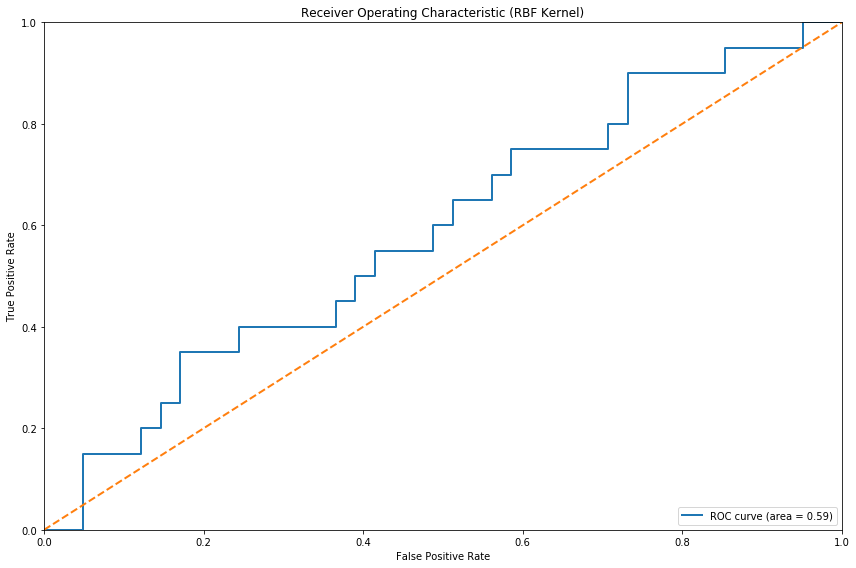

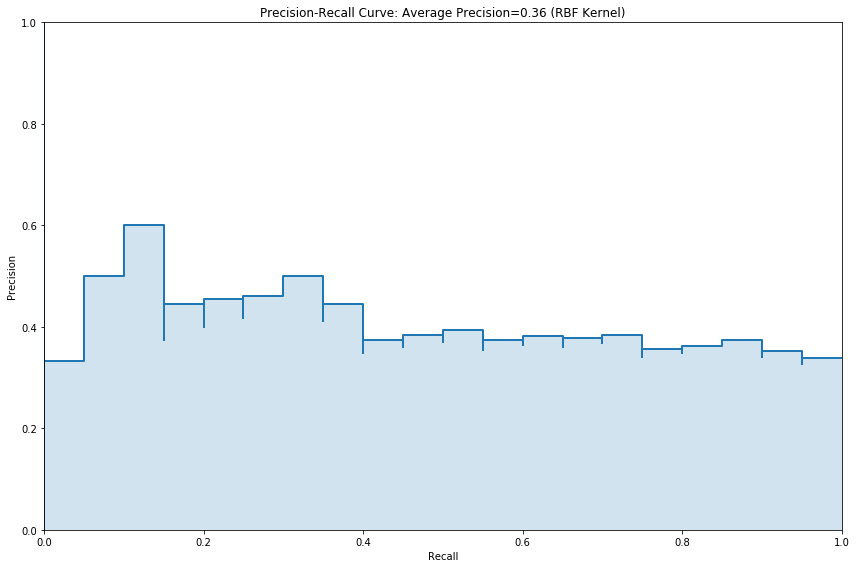

In [213]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import time

start = time.time()

def get_tuned_classifier(df_train_X, df_train_y):
    scoring = {'F1 Score': 'f1'}
    param_grid = [
        {
            'C': np.logspace(-5, 15, num=21, base=2), # 21
            'gamma': np.logspace(-15, 3, num=19, base=2), # 19
            'kernel': ['rbf', 'sigmoid']
        },
        {
            'C': np.logspace(-5, 15, num=21, base=2), # 21,
            'degree': np.arange(2, 17),
            'kernel': ['poly']
        },
        {
            'C': np.logspace(-5, 7, num=21, base=2), # 21
            'kernel': ['linear']
        }
    ]
    gs = GridSearchCV(SVC(probability=True, random_state=RANDOM_STATE),
                      param_grid=param_grid,
                      scoring=scoring,
                      cv=10,
                      refit='F1 Score',
                      n_jobs=4,
                      verbose=50)
    gs.fit(df_train_X, df_train_y)
    best_classifier = gs.best_estimator_
    return best_classifier, gs

classifier_tuned, grid_search_result = get_tuned_classifier(df_train_X, df_train_y)
print_classifier_results(classifier_tuned, df_eval_X, df_eval_y)

end = time.time()
print(end - start)

In [239]:
f1_tuned = cross_val_score(grid_search_result.best_estimator_, df_eval_X, df_eval_y, cv=40, scoring='f1')
f1_baseline_true = cross_val_score(classifier_baseline_true, df_eval_X, df_eval_y, cv=40, scoring='f1')
f1_baseline_false = cross_val_score(classifier_baseline_false, df_eval_X, df_eval_y, cv=40, scoring='f1')

/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 20 members, which is too few. The minimum number of members in any class cannot be less than n_splits=40.
  % (min_groups, self.n_splits)), Warning)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-

In [238]:
from scipy.stats import ttest_rel

In [240]:
ttest_rel(f1_tuned, f1_baseline_false)

Ttest_relResult(statistic=2.0535720530197374, pvalue=0.046765751745517878)

In [241]:
ttest_rel(f1_tuned, f1_baseline_true)

Ttest_relResult(statistic=-4.1977108011346438, pvalue=0.00015094829550734641)

In [242]:
f1_tuned = cross_val_score(grid_search_result.best_estimator_, df_eval_X, df_eval_y, cv=21, scoring='f1')
f1_baseline_true = cross_val_score(classifier_baseline_true, df_eval_X, df_eval_y, cv=21, scoring='f1')
f1_baseline_false = cross_val_score(classifier_baseline_false, df_eval_X, df_eval_y, cv=21, scoring='f1')

/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 20 members, which is too few. The minimum number of members in any class cannot be less than n_splits=21.
  % (min_groups, self.n_splits)), Warning)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-

In [243]:
ttest_rel(f1_tuned, f1_baseline_false)

Ttest_relResult(statistic=2.0755423134660651, pvalue=0.051049166169581751)

In [244]:
ttest_rel(f1_tuned, f1_baseline_true)

Ttest_relResult(statistic=-4.3931373263662366, pvalue=0.00028067718381419819)